# Modeling elections

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan

## Data

The `electoral_votes` variable is a dictionary containing the number of Electoral College votes for each state. For example
```
  >>> electoral_votes['Indiana']
  11
```
Data from [Wikipedia: United_States_Electoral_College](https://en.wikipedia.org/wiki/United_States_Electoral_College)

The `survey_results` variable is a dictionary mapping from states to an array of survey results for each candidate. Each row in a survey results array represents one survey and each column represents one candidate. There are 3 columns, representing Trump (Republican), Biden (Democrat), and Other in that order. In the example below, Trump got 340 votes in the first survey, Biden got 258, and Other got 40.
```
  >>> survey_results['Indiana']
  array([[340, 258,  40],
         [240, 155,  10],
         [235, 155,  70],
         [308, 266,  84],
         [222, 161, 110]])
```
Data from [Wikipedia: Statewide opinion polling for the 2020 United States presidential election](https://en.wikipedia.org/wiki/Statewide_opinion_polling_for_the_2020_United_States_presidential_election)


In [2]:
electoral_votes = {
    'Alabama': 9,
    'Alaska': 3,
    'Arizona': 11,
    'Arkansas': 6,
    'Colorado': 9,
}

survey_results = {
    'Alabama': np.array([[611, 397, 0, 0], [799, 528, 0, 0], [793, 403, 0, 0], [288, 264, 0, 0], [353, 219, 0, 0], [997, 554, 0, 0], [312, 232, 0, 0], [409, 227, 0, 0], [319, 234, 0, 0]]),
    'Alaska': np.array([[348, 320, 0, 0], [298, 253, 0, 0], [283, 277, 0, 0], [269, 198, 0, 0], [227, 177, 0, 0], [442, 389, 0, 0], [519, 486, 0, 0], [325, 318, 0, 0], [84, 74, 0, 0]]),
    'Arizona': np.array([[522, 478, 22, 0], [313, 356, 7, 7], [291, 304, 0, 0], [270, 288, 0, 0], [236, 264, 16, 0], [180, 184, 0, 0], [133, 151, 0, 0], [269, 321, 20, 0], [230, 250, 5, 0], [3337, 3621, 0, 0], [360, 392, 0, 0], [235, 235, 0, 0], [364, 396, 8, 0], [383, 409, 9, 9], [221, 216, 0, 0], [113, 128, 0, 0], [284, 278, 0, 0], [168, 212, 0, 0], [258, 270, 0, 0], [260, 266, 0, 0], [359, 402, 9, 0], [185, 202, 17, 0], [261, 320, 26, 0], [519, 584, 0, 0], [328, 342, 0, 0], [487, 520, 0, 0], [252, 312, 0, 0], [752, 768, 0, 0], [414, 441, 0, 0], [212, 230, 0, 0], [357, 398, 0, 8], [309, 378, 23, 0], [3357, 3034, 0, 0], [396, 490, 0, 0], [162, 169, 0, 0], [325, 402, 9, 9], [445, 426, 0, 0], [311, 350, 0, 0], [188, 193, 0, 0], [466, 456, 30, 0], [271, 295, 0, 0], [204, 192, 0, 0], [522, 547, 24, 12], [2547, 2348, 0, 0], [164, 172, 0, 0], [381, 445, 0, 0], [393, 428, 0, 0], [326, 395, 17, 9], [372, 413, 0, 0], [432, 470, 0, 0], [315, 343, 0, 0], [155, 176, 0, 0], [500, 500, 0, 0], [264, 294, 0, 0], [1230, 1088, 0, 0], [270, 282, 0, 0], [137, 159, 0, 0], [258, 237, 0, 0], [337, 372, 17, 9], [266, 312, 0, 0], [616, 670, 0, 0], [88, 90, 0, 0], [421, 461, 0, 0], [148, 145, 0, 0], [368, 353, 0, 0], [180, 188, 0, 0], [388, 426, 0, 0], [258, 300, 0, 0], [230, 235, 0, 0], [258, 312, 0, 0]]),
    'Arkansas': np.array([[478, 293, 0, 0], [462, 220, 0, 0], [493, 239, 0, 0], [209, 135, 0, 0], [408, 391, 0, 0]]),
    'Colorado': np.array([[408, 510, 0, 0], [1114, 1549, 0, 0], [283, 322, 0, 0], [320, 400, 0, 0], [312, 400, 32, 8], [978, 1359, 0, 0], [262, 325, 0, 0], [252, 306, 0, 0], [246, 307, 0, 0], [246, 306, 0, 0], [240, 312, 0, 0], [935, 1355, 0, 0], [240, 320, 0, 0], [246, 306, 0, 0], [365, 481, 0, 0], [328, 470, 0, 0], [457, 620, 0, 0], [240, 286, 0, 0], [280, 371, 0, 0], [216, 330, 0, 0], [133, 201, 0, 0]]),
}

for key, value in survey_results.items():
    survey_results[key] = np.concatenate((value[:,:2], value[:,2:3] + value[:,3:4]), axis=1)

states = sorted(survey_results.keys())
print('Modeling', len(states), 'states with', sum(electoral_votes[s] for s in states), 'electoral college votes')

Modeling 5 states with 38 electoral college votes


## Generative model

1. For each state we generate an $\vec{\alpha}$ vector, which defines a Dirichlet distribution over the proportion of votes that go to each of the 3 candidates whenever we do a survey – including the final survey, namely the election itself which we want to predict. The prior over each component of $\vec{\alpha}$ is taken as a Cauchy distribution with location 0 and scale 1. Since the components of $\vec{\alpha}$ are positive, we actually use the positive half-Cauchy distribution.

2. For each survey in a state we generate a probability vector $\vec{p_i} \sim \text{Dirichlet}(\vec{\alpha})$ for the probability that a voter selects each of the 3 candidates.

3. For each survey, we then generate the number of votes going to each candidate as $\vec{k_i} \sim \text{Multinomial}(\vec{p_i})$.

### Tasks

* Use Stan to sample from the posterior distribution over $\alpha$ and visualize your results. There are 5 states, so you will have 5 posteriors.
* The posteriors over $\alpha$ show a lot of variation between different states. Explain the results you get in terms of the model and the data.

In [15]:
stan_code = '''

data {
    int<lower=1> C; // number of canidates in the multinomial
    
    int<lower=1> survey_count; // number of surveys
    int counts[survey_count, C];     // the data set: counts for each canidate
}

parameters {
    simplex[C] theta;  // the probability vector over categories
    vector<lower=0>[C] alpha; 
}

model {
    for (i in 1:survey_count) {
        alpha ~ cauchy(0, 1);
        theta ~ dirichlet(alpha);
        counts[i] ~ multinomial(theta);
    }
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0b31b652df70b091f5f624e9027ad2d6 NOW.


In [16]:
# Results for one state
stan_data = {
    'C': 3,
    'survey_count': len(survey_results['Colorado']),
    'counts': survey_results['Colorado']}
results = stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_0b31b652df70b091f5f624e9027ad2d6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.43  5.2e-5 3.6e-3   0.42   0.42   0.43   0.43   0.43   4838    1.0
theta[2]   0.57  5.1e-5 3.6e-3   0.56   0.57   0.57   0.57   0.58   4860    1.0
theta[3] 1.2e-3  3.6e-6 2.6e-4 7.7e-4 1.0e-3 1.2e-3 1.4e-3 1.8e-3   4972    1.0
alpha[1]   0.54  1.7e-3   0.12   0.34   0.45   0.53   0.61   0.79   4399    1.0
alpha[2]    0.6  1.9e-3   0.13   0.37    0.5   0.59   0.68   0.87   4588    1.0
alpha[3]   0.15  4.8e-4   0.03    0.1   0.13   0.15   0.17   0.22   4506    1.0
lp__     -1.3e4    0.04   1.59 -1.3e4 -1.3e4 -1.3e4 -1.3e4 -1.3e4   1943    1.0

Samples were drawn using NUTS at Wed Feb 24 21:49:35 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reductio

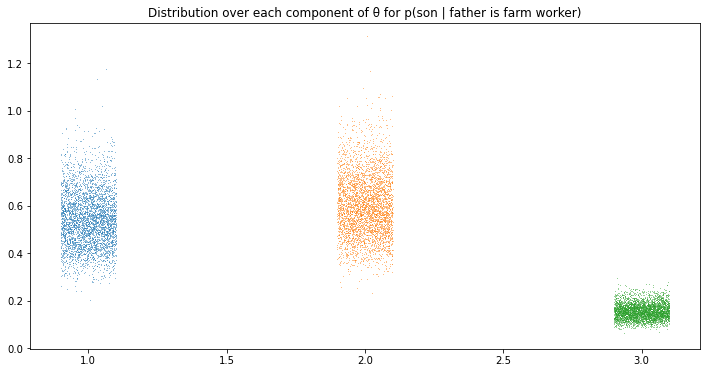

In [18]:
samples = results.extract()
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['alpha'].shape[0]), samples['alpha'][:,i], ',', alpha=0.5)
plt.title('Distribution over each component of θ for p(son | father is farm worker)')
plt.show()

## Simulation time

Use the posterior samples to predict the outcome of the presidential elections.

* Predict the probability that each candidate will win each state.
   * Use the posterior $\alpha$ samples to generate posterior predictive samples for $p$ – the proportion of votes each candidate would get in each state in an election.
   * Use these $p$ samples to estimate the probability that each candidate will win each state.
* Predict the probability that each candidate will win the presidential election.
   * Use the posterior predictive probability that each candidate will win each state to generate samples over the total number Electoral College votes each candidate would get in an election.
   * Use the total number of votes to generate samples over who would win the election.

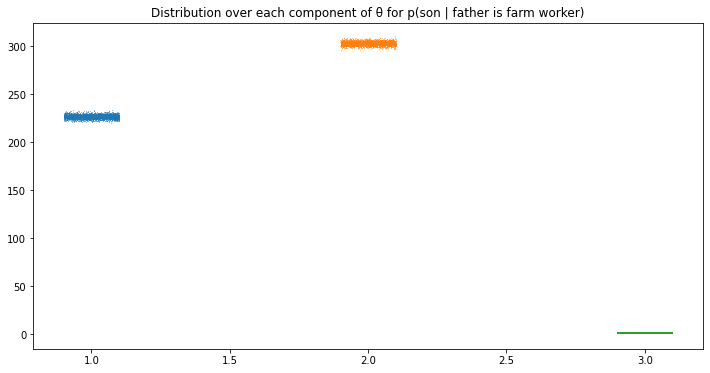

In [19]:
total_votes=528
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['theta'].shape[0]), samples['theta'][:,i]*total_votes, ',', alpha=0.5)
plt.title('Distribution over each component of θ for p(son | father is farm worker)')
plt.show()

In [20]:
# Make a new array with same dimensions as alpha
p_predicted = np.empty(samples['alpha'].shape)
     # Generate one p sample for each alpha sample
for i in range(samples['alpha'].shape[0]):
    p_predicted[i] = sts.dirichlet(samples['alpha'][i]).rvs()

In [21]:
p_predicted

array([[8.09446807e-01, 1.90551347e-01, 1.84549115e-06],
       [2.12784537e-01, 7.65508055e-01, 2.17074073e-02],
       [1.58773645e-01, 8.37988110e-01, 3.23824531e-03],
       ...,
       [1.40594931e-01, 8.55289921e-01, 4.11514860e-03],
       [8.53264404e-01, 1.45336634e-01, 1.39896236e-03],
       [8.99389136e-01, 1.00609556e-01, 1.30806935e-06]])

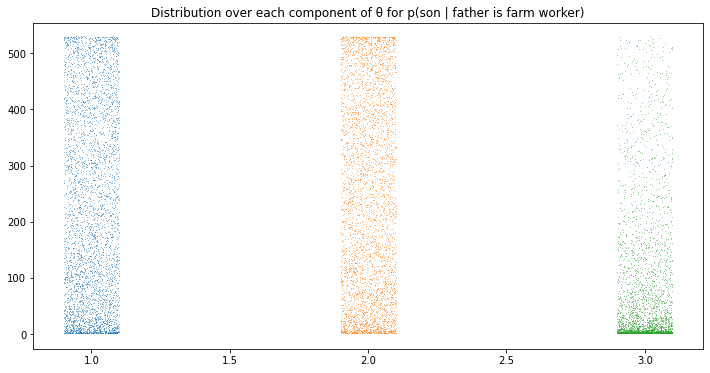

In [22]:
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=p_predicted.shape[0]), p_predicted[:,i]*total_votes, ',', alpha=0.5)
plt.title('Distribution over each component of θ for p(son | father is farm worker)')
plt.show()

Inference for Stan model: anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
theta[1]    0.63  6.8e-4  3.1e-3    0.62    0.63    0.63    0.63    0.63     21   1.16
theta[2]    0.37  6.8e-4  3.1e-3    0.37    0.37    0.37    0.37    0.38     21   1.16
theta[3] 5.9e-17     nan 1.3e-17 5.6e-17 5.6e-17 5.6e-17 5.6e-17 1.1e-16    nan   1.16
alpha[1]    0.57    0.06    0.18    0.26    0.47    0.52    0.69    0.99     10   1.26
alpha[2]    0.52    0.03    0.16    0.24     0.4    0.54    0.59    0.89     32   1.09
alpha[3]    0.03  8.3e-4  7.4e-3    0.02    0.02    0.03    0.03    0.05     81   1.03
lp__       -5046    0.67    1.73   -5050   -5047   -5045   -5045   -5044      7   1.27

Samples were drawn using NUTS at Wed Feb 24 20:04:35 2021.
For each parameter, n_eff is a crude measure of effecti

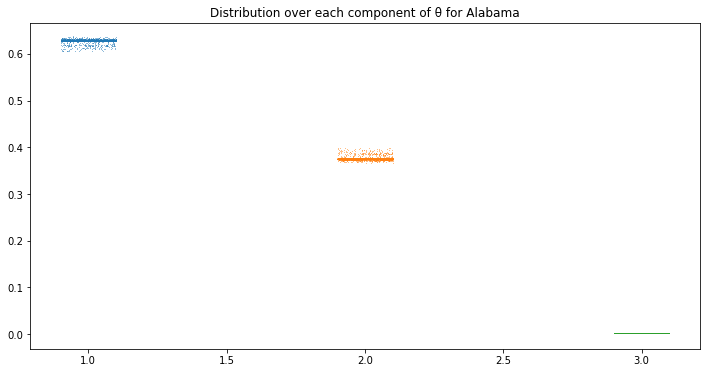

Inference for Stan model: anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
theta[1]    0.53  2.4e-3  7.3e-3    0.51    0.52    0.53    0.53    0.54     10   1.28
theta[2]    0.47  2.4e-3  7.3e-3    0.46    0.47    0.47    0.48    0.49     10   1.28
theta[3] 1.1e-16     nan 1.4e-17 1.1e-16 1.1e-16 1.1e-16 1.1e-16 1.1e-16    nan   1.04
alpha[1]    0.59    0.03    0.17    0.27    0.47    0.58    0.71    0.96     37   1.07
alpha[2]    0.58    0.08    0.24    0.24    0.41    0.55     0.7    1.13      9   1.59
alpha[3]    0.03  9.0e-4  8.8e-3    0.01    0.02    0.03    0.03    0.05     96   1.03
lp__       -3415    0.23     1.5   -3418   -3416   -3415   -3414   -3413     44   1.09

Samples were drawn using NUTS at Wed Feb 24 20:05:59 2021.
For each parameter, n_eff is a crude measure of effecti

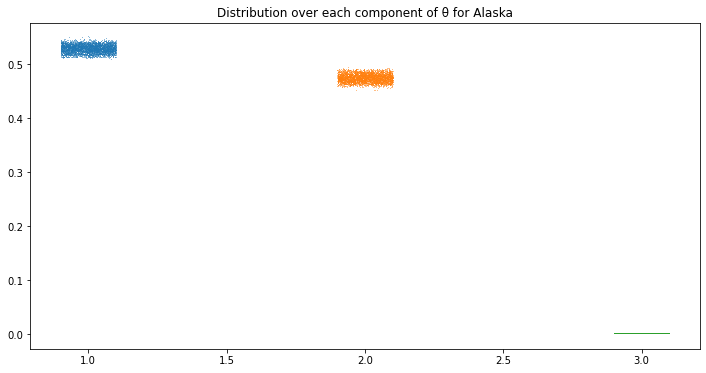

Inference for Stan model: anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.49  2.9e-5 2.0e-3   0.48   0.49   0.49   0.49   0.49   4695    1.0
theta[2]   0.51  2.9e-5 2.0e-3    0.5   0.51   0.51   0.51   0.51   4717    1.0
theta[3] 4.2e-3  3.8e-6 2.5e-4 3.7e-3 4.0e-3 4.2e-3 4.4e-3 4.7e-3   4381    1.0
alpha[1]   0.55  1.0e-3   0.06   0.44   0.51   0.55    0.6   0.69   4077    1.0
alpha[2]   0.56  1.0e-3   0.07   0.44   0.52   0.56   0.61    0.7   4300    1.0
alpha[3]   0.18  3.1e-4   0.02   0.14   0.16   0.18   0.19   0.22   4507    1.0
lp__     -4.5e4    0.03   1.57 -4.5e4 -4.5e4 -4.5e4 -4.5e4 -4.5e4   2226    1.0

Samples were drawn using NUTS at Wed Feb 24 20:06:04 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reductio

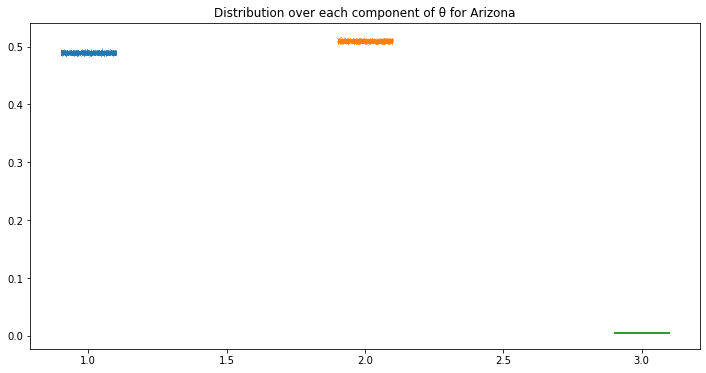

Inference for Stan model: anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
theta[1]    0.63  1.7e-3  6.8e-3    0.61    0.63    0.63    0.63    0.64     16   1.38
theta[2]    0.37  1.7e-3  6.8e-3    0.36    0.37    0.37    0.37    0.39     16   1.38
theta[3] 6.6e-17 5.3e-18 2.4e-17 5.6e-17 5.6e-17 5.6e-17 5.6e-17 1.1e-16     21   1.25
alpha[1]     0.7    0.06     0.3    0.26    0.47    0.66    0.88    1.36     25   1.17
alpha[2]    0.58    0.07    0.25    0.21    0.39    0.55    0.71    1.17     12   1.34
alpha[3]    0.03  2.0e-3    0.01    0.01    0.02    0.03    0.04    0.06     42   1.11
lp__       -2098    0.36    1.83   -2102   -2099   -2098   -2097   -2095     27   1.17

Samples were drawn using NUTS at Wed Feb 24 20:07:11 2021.
For each parameter, n_eff is a crude measure of effecti

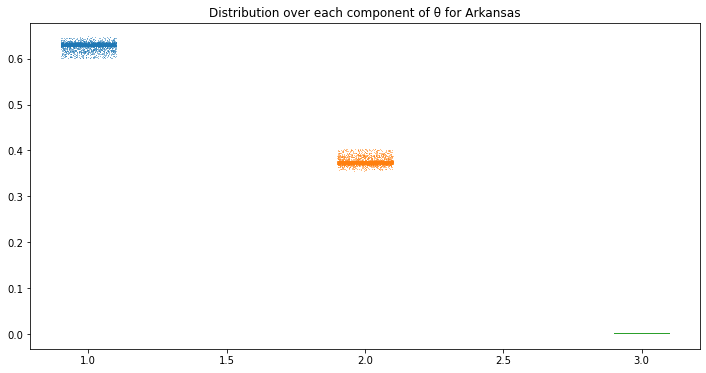

Inference for Stan model: anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.43  5.4e-5 3.5e-3   0.42   0.42   0.43   0.43   0.43   4264    1.0
theta[2]   0.57  5.4e-5 3.5e-3   0.56   0.57   0.57   0.57   0.58   4259    1.0
theta[3] 1.2e-3  4.0e-6 2.6e-4 7.6e-4 1.0e-3 1.2e-3 1.4e-3 1.8e-3   4227    1.0
alpha[1]   0.54  1.9e-3   0.12   0.34   0.46   0.53   0.61    0.8   4010    1.0
alpha[2]    0.6  2.1e-3   0.13   0.37   0.51   0.59   0.68   0.88   3860    1.0
alpha[3]   0.15  5.3e-4   0.03   0.09   0.13   0.15   0.17   0.23   4160    1.0
lp__     -1.3e4    0.04   1.66 -1.3e4 -1.3e4 -1.3e4 -1.3e4 -1.3e4   1808    1.0

Samples were drawn using NUTS at Wed Feb 24 20:07:13 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reductio

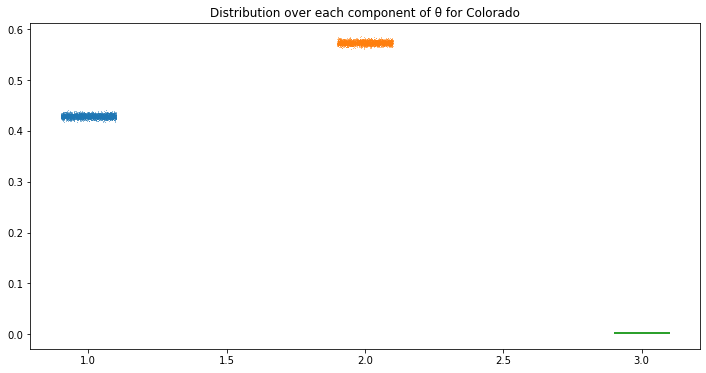

In [65]:
# All states
for state in survey_results.keys():
    # Results for one state
    stan_data = {
        'C': 3,
        'survey_count': len(survey_results[state]),
        'counts': survey_results[state]}
    results = stan_model.sampling(data=stan_data)
    print(results)
    samples = results.extract()
    plt.figure(figsize=(12, 6))
    for i in range(3):
        plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['theta'].shape[0]), samples['theta'][:,i], ',', alpha=0.5)
    plt.title(f'Distribution over each component of θ for {state}')
    plt.show()

## Solution

In [3]:
stan_code = '''
data {
    int S;  // Number of surveys
    int C;  // Number of candidates
    int survey_results[S, C];  // Number of votes for each candidate in each survey
    real cauchy_location;  // Prior hyperparameters for half-Cauchy over alpha
    real cauchy_scale;
}

parameters {
    vector<lower=0>[C] alpha;
    simplex[C] p[S];  // One probability vector for each survey
}

model {
    alpha ~ cauchy(cauchy_location, cauchy_scale);
    for (i in 1:S) {
        p[i] ~ dirichlet(alpha);
        survey_results[i] ~ multinomial(p[i]);
    }
}
'''
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a89b9d288c9c4fecf50d2e6275e90c2e NOW.


Posterior α samples and 95% confidence intervals for each state



Alabama
[[1.19819586e+01 7.69957080e+00 4.71705912e-02]
 [1.95068407e+02 1.26792449e+02 2.80948689e-01]]


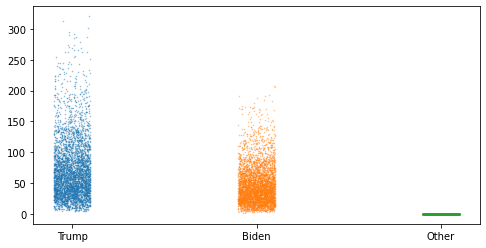

Alaska
[[3.09308179e+01 2.78229073e+01 5.47953836e-02]
 [9.42284017e+02 8.09156875e+02 6.50726838e-01]]


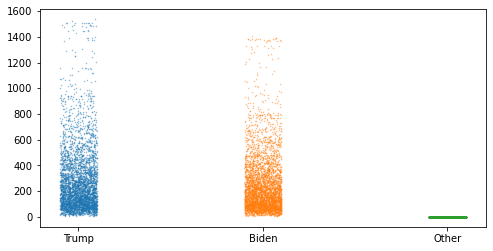

Arizona
[[30.87533302 33.33903035  0.12322809]
 [59.35984699 63.64294658  0.2898842 ]]


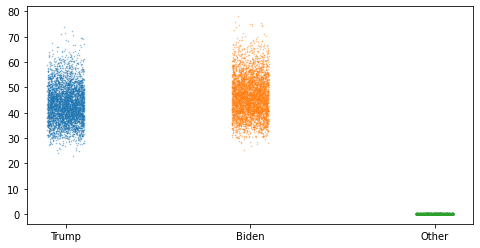

Arkansas
[[1.42733167e+00 1.00189251e+00 3.23604411e-02]
 [5.93646720e+01 3.71509345e+01 2.88352233e-01]]


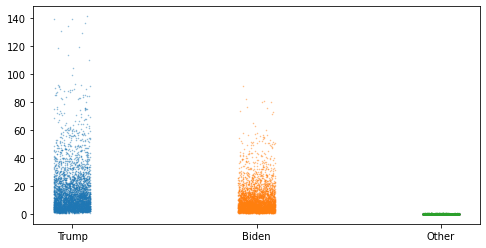

Colorado
[[2.77573101e+01 3.59582265e+01 6.32365043e-02]
 [1.28417902e+02 1.67742875e+02 2.38666183e-01]]


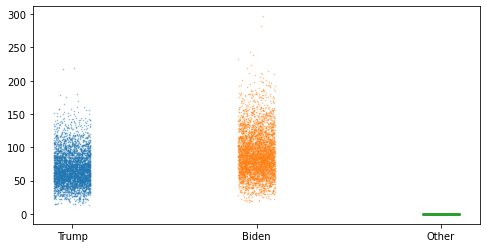

In [4]:
# Sample results for all states

print('Posterior α samples and 95% confidence intervals for each state\n')

results = {}
for state in states:
    data = {
        'S': survey_results[state].shape[0],
        'C': 3,
        'survey_results': survey_results[state],
        'cauchy_location': 0,
        'cauchy_scale': 1}
    results[state] = stan_model.sampling(data=data)
    samples = results[state].extract()

    print(state)
    print(np.percentile(samples['alpha'], [2.5, 97.5], axis=0))
    plt.figure(figsize=(8,4))
    for i in range(3):
        plt.plot(sts.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), samples['alpha'][:,i], '.', markersize=1, alpha=0.5)
    plt.xticks([0, 1, 2], ['Trump', 'Biden', 'Other'])
    plt.show()

## All the states

In [5]:
electoral_votes = {
    'California': 55, 'Texas': 38, 'Florida': 29, 'New York': 29, 'Illinois': 20,
    'Pennsylvania': 20, 'Ohio': 18, 'Georgia': 16, 'Michigan': 16,
    'North Carolina': 15, 'New Jersey': 14, 'Virginia': 13, 'Washington': 12,
    'Arizona': 11, 'Indiana': 11, 'Massachusetts': 11, 'Tennessee': 11,
    'Maryland': 10, 'Minnesota': 10, 'Missouri': 10, 'Wisconsin': 10, 'Alabama': 9,
    'Colorado': 9, 'South Carolina': 9, 'Kentucky': 8, 'Louisiana': 8,
    'Connecticut': 7, 'Oklahoma': 7, 'Oregon': 7, 'Arkansas': 6, 'Iowa': 6,
    'Kansas': 6, 'Mississippi': 6, 'Nevada': 6, 'Utah': 6, 'Nebraska': 5,
    'New Mexico': 5, 'West Virginia': 5, 'Hawaii': 4, 'Idaho': 4, 'Maine': 4,
    'New Hampshire': 4, 'Rhode Island': 4, 'Alaska': 3, 'Delaware': 3,
    'District of Columbia': 3, 'Montana': 3, 'North Dakota': 3, 'South Dakota': 3,
    'Vermont': 3, 'Wyoming': 3}

survey_results = {
    'Alabama': np.array([[611, 397, 0, 0], [799, 528, 0, 0], [793, 403, 0, 0], [288, 264, 0, 0], [353, 219, 0, 0], [997, 554, 0, 0], [312, 232, 0, 0], [409, 227, 0, 0], [319, 234, 0, 0]]),
    'Alaska': np.array([[348, 320, 0, 0], [298, 253, 0, 0], [283, 277, 0, 0], [269, 198, 0, 0], [227, 177, 0, 0], [442, 389, 0, 0], [519, 486, 0, 0], [325, 318, 0, 0], [84, 74, 0, 0]]),
    'Arizona': np.array([[522, 478, 22, 0], [313, 356, 7, 7], [291, 304, 0, 0], [270, 288, 0, 0], [236, 264, 16, 0], [180, 184, 0, 0], [133, 151, 0, 0], [269, 321, 20, 0], [230, 250, 5, 0], [3337, 3621, 0, 0], [360, 392, 0, 0], [235, 235, 0, 0], [364, 396, 8, 0], [383, 409, 9, 9], [221, 216, 0, 0], [113, 128, 0, 0], [284, 278, 0, 0], [168, 212, 0, 0], [258, 270, 0, 0], [260, 266, 0, 0], [359, 402, 9, 0], [185, 202, 17, 0], [261, 320, 26, 0], [519, 584, 0, 0], [328, 342, 0, 0], [487, 520, 0, 0], [252, 312, 0, 0], [752, 768, 0, 0], [414, 441, 0, 0], [212, 230, 0, 0], [357, 398, 0, 8], [309, 378, 23, 0], [3357, 3034, 0, 0], [396, 490, 0, 0], [162, 169, 0, 0], [325, 402, 9, 9], [445, 426, 0, 0], [311, 350, 0, 0], [188, 193, 0, 0], [466, 456, 30, 0], [271, 295, 0, 0], [204, 192, 0, 0], [522, 547, 24, 12], [2547, 2348, 0, 0], [164, 172, 0, 0], [381, 445, 0, 0], [393, 428, 0, 0], [326, 395, 17, 9], [372, 413, 0, 0], [432, 470, 0, 0], [315, 343, 0, 0], [155, 176, 0, 0], [500, 500, 0, 0], [264, 294, 0, 0], [1230, 1088, 0, 0], [270, 282, 0, 0], [137, 159, 0, 0], [258, 237, 0, 0], [337, 372, 17, 9], [266, 312, 0, 0], [616, 670, 0, 0], [88, 90, 0, 0], [421, 461, 0, 0], [148, 145, 0, 0], [368, 353, 0, 0], [180, 188, 0, 0], [388, 426, 0, 0], [258, 300, 0, 0], [230, 235, 0, 0], [258, 312, 0, 0]]),
    'Arkansas': np.array([[478, 293, 0, 0], [462, 220, 0, 0], [493, 239, 0, 0], [209, 135, 0, 0], [408, 391, 0, 0]]),
    'California': np.array([[7121, 12818, 0, 0], [200, 347, 0, 0], [497, 1100, 18, 18], [1664, 3981, 0, 0], [362, 701, 35, 23], [234, 336, 0, 0], [6138, 11048, 0, 0], [248, 488, 0, 0], [476, 1161, 19, 19], [6659, 11987, 0, 0], [1892, 4527, 0, 0], [3028, 5215, 0, 0], [346, 597, 0, 0], [161, 311, 0, 0], [280, 520, 0, 0]]),
    'Colorado': np.array([[408, 510, 0, 0], [1114, 1549, 0, 0], [283, 322, 0, 0], [320, 400, 0, 0], [312, 400, 32, 8], [978, 1359, 0, 0], [262, 325, 0, 0], [252, 306, 0, 0], [246, 307, 0, 0], [246, 306, 0, 0], [240, 312, 0, 0], [935, 1355, 0, 0], [240, 320, 0, 0], [246, 306, 0, 0], [365, 481, 0, 0], [328, 470, 0, 0], [457, 620, 0, 0], [240, 286, 0, 0], [280, 371, 0, 0], [216, 330, 0, 0], [133, 201, 0, 0]]),
    'Connecticut': np.array([[524, 863, 0, 0], [353, 646, 0, 0], [530, 802, 0, 0], [184, 373, 0, 0], [267, 420, 0, 0], [312, 529, 0, 0]]),
    'Delaware': np.array([[146, 241, 0, 0], [280, 457, 17, 8], [111, 233, 0, 0], [263, 412, 0, 0], [140, 304, 0, 0], [79, 148, 0, 0]]),
    'District of Columbia': np.array([[41, 295, 0, 0], [40, 209, 0, 0], [23, 264, 0, 0], [17, 131, 0, 0]]),
    'Florida': np.array([[294, 276, 6, 0], [305, 332, 0, 0], [439, 489, 10, 0], [502, 641, 0, 0], [258, 280, 0, 0], [225, 225, 10, 0], [1410, 1598, 0, 0], [215, 244, 0, 0], [298, 334, 14, 7], [6092, 6611, 0, 0], [264, 294, 0, 0], [215, 230, 15, 0], [461, 515, 11, 11], [1366, 1453, 0, 0], [267, 285, 0, 0], [323, 344, 0, 0], [313, 288, 0, 0], [180, 204, 0, 0], [554, 578, 0, 0], [275, 275, 0, 0], [510, 544, 12, 12], [193, 214, 9, 0], [424, 434, 0, 0], [316, 316, 0, 0], [1264, 1344, 0, 0], [736, 768, 0, 0], [1683, 1957, 0, 0], [526, 561, 0, 0], [365, 365, 0, 0], [501, 470, 20, 0], [470, 525, 11, 11], [368, 408, 0, 0], [556, 593, 0, 0], [6143, 5897, 0, 0], [1781, 1857, 0, 0], [294, 342, 0, 0], [581, 618, 0, 0], [295, 322, 0, 0], [525, 627, 13, 0], [1568, 1742, 0, 0], [330, 345, 15, 0], [206, 234, 0, 0], [196, 196, 0, 0], [6694, 6833, 0, 0], [308, 329, 0, 0], [1730, 1842, 0, 0], [405, 449, 0, 0], [349, 349, 24, 16], [288, 312, 0, 0], [460, 538, 11, 11], [351, 471, 0, 0], [1328, 1509, 0, 0], [221, 272, 0, 0], [485, 564, 0, 0], [507, 579, 0, 0], [493, 493, 0, 0], [2888, 2662, 0, 0], [428, 476, 0, 0], [404, 495, 0, 0], [267, 306, 0, 0], [442, 486, 11, 11], [307, 356, 0, 0], [350, 446, 0, 0], [534, 569, 0, 0], [386, 414, 0, 0], [2224, 2262, 0, 0], [1725, 1689, 0, 0], [946, 967, 21, 0], [1032, 1117, 0, 0], [436, 456, 0, 0], [436, 492, 0, 0], [432, 462, 0, 0], [582, 637, 0, 0], [2716, 2716, 0, 0]]),
    'Georgia': np.array([[243, 248, 0, 0], [292, 281, 4, 0], [520, 509, 33, 0], [225, 235, 15, 0], [1665, 1699, 0, 0], [455, 484, 0, 0], [188, 200, 0, 0], [529, 562, 0, 0], [347, 355, 16, 0], [547, 535, 0, 0], [189, 185, 8, 0], [235, 235, 10, 0], [540, 540, 12, 0], [360, 360, 8, 0], [276, 294, 0, 0], [368, 360, 16, 0], [713, 684, 0, 0], [368, 376, 0, 0], [240, 205, 10, 0], [1358, 1358, 0, 0], [640, 682, 0, 0], [743, 840, 0, 0], [360, 368, 0, 0], [595, 582, 0, 0], [240, 225, 20, 0], [274, 287, 0, 0], [499, 510, 0, 0], [160, 176, 0, 0], [1985, 1685, 0, 0], [189, 189, 12, 0], [615, 628, 0, 0], [325, 332, 0, 0], [512, 440, 20, 0], [343, 322, 0, 0], [344, 376, 0, 0], [246, 231, 0, 0], [1009, 1009, 0, 0], [330, 360, 0, 0], [456, 476, 0, 0], [304, 317, 0, 0], [141, 128, 0, 0], [684, 656, 0, 0], [629, 643, 0, 0], [1360, 1360, 0, 0], [336, 322, 0, 0], [230, 235, 0, 0], [266, 260, 0, 0]]),
    'Hawaii': np.array([[156, 313, 0, 0], [134, 221, 0, 0], [132, 221, 0, 0], [283, 546, 0, 0], [62, 139, 0, 0]]),
    'Idaho': np.array([[487, 266, 0, 0], [360, 204, 0, 0], [427, 295, 0, 0], [423, 235, 0, 0], [154, 109, 0, 0]]),
    'Illinois': np.array([[3021, 5119, 0, 0], [483, 640, 0, 0], [2574, 4064, 0, 0], [2875, 4463, 0, 0], [1170, 1770, 0, 0]]),
    'Indiana': np.array([[1255, 1065, 0, 0], [547, 403, 52, 0], [920, 719, 0, 0], [495, 342, 0, 0], [1218, 935, 0, 0], [530, 372, 0, 0], [438, 349, 0, 0], [531, 398, 0, 0]]),
    'Iowa': np.array([[507, 507, 0, 0], [355, 363, 0, 0], [542, 602, 0, 0], [664, 587, 0, 0], [349, 327, 7, 7], [196, 188, 0, 0], [359, 374, 0, 0], [201, 177, 8, 0], [210, 225, 10, 0], [309, 309, 0, 0], [376, 360, 0, 0], [521, 452, 0, 0], [192, 180, 12, 0], [484, 462, 33, 11], [86, 98, 0, 0], [591, 493, 0, 0], [205, 200, 0, 0], [537, 525, 0, 0], [322, 336, 0, 0], [228, 218, 0, 0], [297, 290, 0, 0], [398, 398, 0, 0], [462, 453, 0, 0], [587, 562, 0, 0], [240, 225, 0, 0]]),
    'Kansas': np.array([[590, 533, 0, 0], [352, 284, 0, 0], [424, 371, 26, 0], [421, 326, 0, 0], [498, 415, 0, 0], [577, 493, 0, 0], [432, 372, 0, 0], [660, 609, 0, 0], [247, 210, 0, 0], [363, 280, 0, 0], [832, 669, 0, 0]]),
    'Kentucky': np.array([[873, 577, 0, 0], [444, 282, 8, 0], [675, 442, 0, 0], [739, 468, 0, 0], [454, 373, 0, 0], [468, 278, 0, 0], [1060, 632, 0, 0], [1570, 1359, 0, 0], [360, 204, 0, 0], [424, 328, 0, 0], [358, 226, 0, 0], [512, 332, 0, 0], [265, 180, 0, 0], [607, 431, 0, 0], [2200, 1360, 0, 0]]),
    'Louisiana': np.array([[1485, 940, 0, 0], [288, 252, 12, 0], [1526, 983, 0, 0], [541, 381, 30, 0], [400, 344, 0, 0], [1799, 1169, 0, 0], [680, 420, 0, 0]]),
    'Maine': np.array([[186, 238, 0, 0], [277, 437, 0, 0], [280, 381, 0, 0], [330, 424, 0, 0], [195, 255, 0, 0], [252, 365, 0, 0], [450, 698, 0, 0], [320, 432, 0, 0], [186, 306, 0, 0], [172, 204, 0, 0], [298, 419, 0, 0], [195, 250, 0, 0], [364, 424, 0, 0], [301, 418, 0, 0], [404, 510, 0, 0], [337, 444, 0, 0], [429, 542, 0, 0], [93, 103, 0, 0], [70, 144, 0, 0], [150, 225, 0, 0], [88, 144, 0, 0], [226, 452, 0, 0], [152, 251, 0, 0], [82, 122, 0, 0], [118, 239, 0, 0], [149, 234, 0, 0], [115, 96, 0, 0], [183, 196, 0, 0], [105, 110, 0, 0], [198, 207, 0, 0], [209, 252, 0, 0], [165, 180, 0, 0], [196, 192, 0, 0], [95, 97, 0, 0], [172, 168, 0, 0], [189, 202, 0, 0]]),
    'Maryland': np.array([[233, 473, 16, 16], [208, 396, 0, 0], [733, 1584, 0, 0], [226, 467, 0, 0], [562, 1197, 0, 0], [612, 1261, 0, 0], [400, 752, 0, 0], [251, 478, 0, 0]]),
    'Massachusetts': np.array([[850, 1752, 0, 0], [663, 1577, 0, 0], [237, 526, 0, 0], [135, 316, 0, 0], [140, 305, 0, 0], [652, 1806, 0, 0], [183, 438, 0, 0], [295, 775, 0, 0], [244, 496, 0, 0], [300, 580, 0, 0]]),
    'Michigan': np.array([[547, 619, 0, 0], [488, 567, 11, 11], [308, 387, 0, 0], [294, 350, 7, 0], [305, 362, 0, 0], [291, 345, 0, 0], [234, 288, 0, 0], [328, 373, 15, 7], [1451, 1747, 0, 0], [490, 511, 21, 0], [330, 400, 8, 0], [352, 415, 0, 0], [352, 416, 0, 0], [474, 467, 21, 8], [420, 500, 10, 0], [288, 327, 0, 0], [244, 290, 0, 0], [180, 200, 0, 0], [191, 218, 5, 0], [246, 276, 0, 0], [280, 312, 0, 0], [217, 274, 0, 0], [363, 456, 19, 9], [240, 288, 0, 0], [688, 800, 0, 0], [611, 757, 0, 0], [377, 429, 0, 0], [440, 530, 0, 0], [252, 282, 0, 0], [387, 493, 10, 0], [1422, 1451, 0, 0], [598, 740, 0, 0], [395, 431, 27, 9], [356, 404, 0, 0], [493, 472, 31, 0], [309, 406, 8, 8], [290, 309, 0, 0], [533, 606, 0, 0], [246, 312, 0, 0], [178, 198, 0, 0], [327, 358, 0, 0], [535, 647, 0, 0], [82, 102, 0, 0], [1480, 1511, 0, 0], [240, 306, 18, 0], [377, 429, 0, 0], [173, 190, 0, 0], [554, 686, 0, 0], [486, 555, 0, 0], [300, 397, 8, 8], [371, 482, 0, 0], [317, 385, 0, 0], [302, 370, 0, 0], [246, 318, 0, 0], [300, 270, 0, 0], [346, 396, 0, 0], [458, 531, 0, 0], [569, 631, 0, 0], [301, 336, 0, 0], [544, 618, 0, 0], [228, 336, 0, 0], [495, 506, 0, 0], [220, 287, 0, 0], [297, 388, 17, 8], [330, 490, 0, 0], [159, 166, 0, 0], [326, 438, 0, 0], [190, 272, 0, 0], [234, 330, 0, 0], [246, 318, 0, 0], [285, 298, 0, 0], [696, 791, 0, 0], [556, 662, 0, 0], [555, 629, 0, 0], [1412, 1504, 0, 0], [378, 456, 0, 0], [252, 300, 0, 0], [533, 635, 0, 0], [562, 651, 0, 0], [328, 392, 0, 0], [233, 282, 0, 0], [258, 294, 0, 0], [124, 152, 0, 0]]),
    'Minnesota': np.array([[372, 437, 0, 0], [1207, 1544, 0, 0], [200, 235, 10, 0], [336, 384, 0, 0], [302, 366, 0, 0], [252, 351, 0, 0], [283, 309, 0, 0], [446, 544, 0, 0], [334, 407, 16, 8], [221, 271, 0, 0], [286, 318, 0, 0], [386, 456, 0, 0], [225, 240, 0, 0], [834, 1086, 0, 0], [278, 324, 0, 0], [536, 536, 46, 0], [258, 308, 0, 0], [359, 374, 0, 0], [72, 108, 0, 0], [1075, 1167, 0, 0], [291, 311, 0, 0], [497, 553, 23, 0], [512, 633, 0, 0], [295, 396, 0, 0], [361, 490, 0, 0], [252, 348, 0, 0], [270, 288, 0, 0], [214, 255, 0, 0], [272, 317, 0, 0], [352, 392, 0, 0], [228, 330, 0, 0]]),
    'Mississippi': np.array([[430, 344, 0, 0], [370, 219, 0, 0], [300, 240, 0, 0], [318, 258, 0, 0], [432, 286, 0, 0], [268, 149, 0, 0], [284, 233, 0, 0], [249, 193, 0, 0]]),
    'Missouri': np.array([[300, 288, 0, 0], [500, 451, 0, 0], [1143, 971, 0, 0], [554, 471, 0, 0], [245, 220, 0, 0], [1006, 820, 0, 0], [528, 416, 0, 0], [1221, 995, 0, 0], [450, 387, 0, 0], [443, 408, 0, 0], [368, 384, 0, 0], [588, 495, 0, 0], [240, 220, 0, 0]]),
    'Montana': np.array([[415, 367, 0, 0], [280, 220, 0, 0], [361, 317, 22, 0], [274, 197, 0, 0], [306, 262, 12, 0], [400, 344, 0, 0], [292, 259, 0, 0], [192, 176, 0, 0], [315, 269, 0, 0], [279, 232, 0, 0], [458, 413, 0, 0], [364, 294, 0, 0], [428, 393, 0, 0], [624, 514, 0, 0], [95, 68, 0, 0], [269, 196, 0, 0], [207, 184, 0, 0], [873, 719, 0, 0]]),
    'Nebraska': np.array([[455, 328, 0, 0], [297, 263, 0, 0], [491, 400, 0, 0], [150, 112, 0, 0], [192, 184, 0, 0], [189, 238, 0, 0], [172, 202, 0, 0], [176, 200, 0, 0], [180, 204, 0, 0], [221, 256, 0, 0], [184, 233, 0, 0]]),
    'Nevada': np.array([[477, 539, 0, 0], [277, 317, 20, 0], [582, 632, 0, 0], [360, 368, 0, 0], [263, 295, 0, 0], [332, 421, 24, 0], [344, 376, 0, 0], [194, 213, 14, 0], [489, 499, 0, 0], [266, 300, 0, 0], [531, 480, 0, 0], [298, 304, 0, 0], [343, 374, 0, 0]]),
    'New Hampshire': np.array([[470, 608, 0, 0], [315, 371, 0, 0], [274, 350, 0, 0], [264, 318, 6, 0], [428, 515, 10, 0], [357, 476, 0, 0], [289, 342, 7, 0], [187, 200, 18, 0], [173, 266, 0, 0], [448, 531, 0, 0], [224, 344, 0, 0], [757, 1003, 0, 0], [74, 117, 0, 0], [365, 487, 0, 0], [450, 525, 0, 0], [363, 348, 0, 0], [344, 410, 0, 0]]),
    'New Jersey': np.array([[221, 308, 0, 0], [1092, 1771, 0, 0], [190, 261, 0, 0], [200, 290, 0, 0], [924, 1316, 0, 0], [255, 245, 0, 0], [898, 1480, 0, 0], [165, 255, 0, 0], [411, 677, 0, 0], [329, 508, 0, 0], [227, 386, 0, 0], [241, 343, 0, 0]]),
    'New Mexico': np.array([[346, 470, 0, 0], [447, 548, 0, 0], [438, 606, 0, 0], [467, 609, 0, 0], [434, 443, 0, 0], [253, 248, 0, 0], [289, 392, 0, 0], [436, 567, 0, 0]]),
    'New York': np.array([[3402, 6404, 0, 0], [146, 307, 0, 0], [3389, 6380, 0, 0], [329, 648, 0, 0], [3495, 6476, 0, 0], [1503, 2961, 0, 0], [258, 459, 0, 0], [245, 437, 0, 0], [293, 503, 0, 0], [233, 522, 0, 0]]),
    'North Carolina': np.array([[413, 460, 9, 0], [419, 456, 0, 0], [565, 655, 26, 0], [282, 282, 0, 0], [186, 194, 0, 0], [567, 616, 0, 0], [1608, 1817, 0, 0], [386, 411, 0, 0], [188, 196, 0, 0], [494, 516, 22, 0], [558, 582, 0, 0], [433, 433, 18, 9], [317, 324, 14, 0], [266, 278, 0, 0], [275, 269, 12, 0], [351, 366, 0, 0], [287, 294, 13, 7], [275, 275, 0, 0], [491, 513, 11, 11], [214, 231, 24, 1], [280, 280, 0, 0], [362, 386, 16, 8], [504, 527, 0, 0], [500, 482, 17, 5], [490, 480, 0, 0], [768, 768, 0, 0], [748, 764, 0, 0], [208, 217, 0, 0], [418, 409, 10, 10], [180, 188, 12, 0], [332, 361, 7, 0], [1486, 1399, 0, 0], [539, 517, 0, 0], [736, 768, 0, 0], [263, 269, 0, 0], [709, 755, 0, 0], [445, 425, 19, 0], [687, 732, 0, 0], [590, 590, 0, 0], [343, 330, 0, 0], [264, 270, 12, 6], [237, 232, 0, 0], [360, 352, 0, 0], [526, 573, 0, 0], [430, 458, 0, 0], [497, 542, 0, 0], [148, 188, 0, 0], [1733, 1698, 0, 0], [131, 139, 0, 0], [707, 707, 0, 0], [407, 433, 0, 0], [353, 345, 7, 0], [324, 356, 32, 8], [388, 450, 0, 0], [386, 395, 18, 9], [294, 276, 0, 0], [268, 263, 5, 0], [301, 308, 0, 0], [376, 409, 0, 0], [734, 734, 0, 0], [206, 239, 0, 0], [506, 517, 0, 0], [532, 555, 0, 0], [455, 476, 0, 0], [261, 320, 0, 0], [290, 271, 0, 0], [361, 415, 9, 0], [170, 178, 4, 4], [411, 447, 0, 0]]),
    'North Dakota': np.array([[157, 85, 0, 0], [235, 170, 0, 0], [280, 185, 0, 0], [178, 86, 0, 0], [164, 94, 0, 0], [62, 25, 0, 0]]),
    'Ohio': np.array([[474, 454, 10, 0], [291, 297, 13, 7], [497, 455, 31, 10], [524, 524, 0, 0], [2046, 1886, 0, 0], [196, 188, 0, 0], [374, 415, 8, 8], [507, 517, 0, 0], [445, 455, 20, 0], [267, 250, 0, 0], [982, 883, 0, 0], [470, 510, 0, 0], [230, 240, 0, 0], [1642, 1546, 0, 0], [906, 815, 0, 0], [297, 297, 0, 0], [855, 785, 0, 0], [575, 587, 0, 0], [1921, 1699, 0, 0], [836, 783, 0, 0], [557, 545, 0, 0], [330, 346, 32, 8], [345, 375, 0, 0], [436, 477, 0, 0], [805, 789, 0, 0], [513, 524, 0, 0], [345, 361, 0, 0]]),
    'Oklahoma': np.array([[740, 411, 0, 0], [275, 165, 0, 0], [292, 170, 0, 0], [646, 353, 0, 0], [902, 479, 0, 0], [320, 206, 0, 0], [361, 219, 0, 0], [275, 180, 0, 0]]),
    'Oregon': np.array([[801, 1286, 0, 0], [368, 529, 0, 0], [196, 256, 0, 0], [626, 989, 0, 0], [718, 1153, 0, 0], [340, 514, 0, 0]]),
    'Pennsylvania': np.array([[513, 570, 11, 0], [389, 454, 9, 0], [323, 351, 0, 0], [497, 654, 0, 0], [272, 302, 0, 0], [215, 234, 0, 0], [210, 270, 5, 0], [566, 656, 0, 0], [297, 346, 21, 0], [2122, 2399, 0, 0], [255, 306, 0, 0], [284, 348, 14, 0], [348, 387, 0, 0], [447, 508, 0, 0], [377, 437, 17, 0], [455, 476, 20, 0], [463, 483, 10, 10], [289, 315, 0, 0], [261, 284, 0, 0], [202, 230, 0, 0], [168, 212, 0, 0], [374, 415, 0, 0], [453, 473, 20, 10], [281, 299, 0, 0], [317, 366, 0, 0], [456, 508, 10, 10], [283, 316, 0, 0], [736, 784, 0, 0], [339, 409, 0, 0], [1002, 1114, 0, 0], [381, 414, 0, 0], [367, 426, 0, 0], [209, 219, 0, 0], [453, 505, 11, 11], [543, 642, 0, 0], [220, 250, 0, 0], [180, 196, 8, 0], [270, 306, 0, 0], [1589, 1871, 0, 0], [971, 1057, 0, 0], [460, 460, 0, 0], [418, 505, 0, 0], [286, 340, 0, 0], [453, 482, 0, 0], [336, 400, 16, 8], [412, 483, 10, 10], [271, 315, 0, 0], [187, 204, 0, 0], [782, 888, 0, 0], [396, 447, 0, 0], [201, 219, 0, 0], [521, 593, 0, 0], [184, 200, 0, 0], [304, 371, 0, 0], [2020, 2104, 0, 0], [176, 183, 0, 0], [273, 334, 0, 0], [879, 1046, 0, 0], [453, 483, 0, 0], [348, 356, 32, 16], [270, 306, 0, 0], [417, 488, 10, 0], [309, 396, 0, 0], [345, 382, 0, 0], [336, 329, 0, 0], [160, 213, 0, 0], [312, 372, 0, 0], [457, 510, 0, 0], [1048, 1092, 0, 0], [334, 380, 0, 0], [293, 329, 0, 0], [439, 551, 11, 11], [260, 326, 0, 0], [226, 241, 0, 0], [252, 324, 0, 0], [290, 266, 0, 0], [933, 1018, 0, 0], [376, 462, 0, 0], [306, 276, 0, 0], [277, 316, 0, 0], [550, 638, 0, 0], [337, 402, 0, 0], [231, 266, 0, 0], [291, 333, 0, 0], [282, 282, 0, 0]]),
    'Rhode Island': np.array([[130, 218, 0, 0], [85, 119, 0, 0], [99, 152, 0, 0], [70, 106, 0, 0]]),
    'South Carolina': np.array([[971, 825, 0, 0], [392, 352, 0, 0], [387, 354, 0, 0], [539, 528, 0, 0], [562, 454, 0, 0], [382, 336, 0, 0], [494, 436, 0, 0], [390, 336, 0, 0], [397, 321, 0, 0], [703, 597, 0, 0], [390, 329, 0, 0], [382, 329, 0, 0], [430, 384, 0, 0], [363, 326, 0, 0], [367, 344, 0, 0], [901, 748, 0, 0], [382, 329, 0, 0], [296, 266, 0, 0], [302, 278, 0, 0], [400, 344, 0, 0], [449, 406, 0, 0], [307, 248, 0, 0]]),
    'South Dakota': np.array([[205, 145, 0, 0], [163, 105, 0, 0], [246, 139, 0, 0], [98, 59, 0, 0]]),
    'Tennessee': np.array([[1351, 955, 0, 0], [1060, 718, 0, 0], [1513, 943, 0, 0], [666, 404, 0, 0], [510, 420, 0, 0], [284, 193, 0, 0]]),
    'Texas': np.array([[346, 346, 0, 0], [510, 440, 0, 0], [430, 430, 0, 0], [877, 916, 39, 19], [454, 409, 18, 18], [416, 416, 0, 0], [6965, 6162, 0, 0], [196, 188, 0, 0], [294, 294, 0, 0], [432, 406, 18, 9], [341, 327, 0, 0], [300, 281, 7, 7], [539, 485, 0, 0], [542, 519, 0, 0], [1301, 1301, 0, 0], [357, 349, 0, 0], [441, 423, 9, 9], [6556, 5799, 0, 0], [1263, 1237, 0, 0], [399, 435, 0, 0], [1033, 1102, 0, 0], [359, 367, 0, 0], [1203, 1177, 0, 0], [315, 329, 0, 0], [406, 347, 8, 8], [497, 436, 20, 0], [1185, 1211, 0, 0], [7135, 6312, 0, 0], [1208, 1262, 0, 0], [368, 338, 0, 0], [387, 396, 0, 0], [545, 533, 0, 0], [272, 260, 0, 0], [721, 805, 0, 0], [3401, 3068, 0, 0], [576, 528, 0, 0], [335, 350, 0, 0], [440, 450, 0, 0], [435, 417, 0, 0], [328, 328, 0, 0], [513, 501, 0, 0], [1276, 1097, 0, 0], [416, 384, 0, 0], [475, 485, 0, 0], [509, 509, 0, 0], [588, 528, 0, 0]]),
    'Utah': np.array([[607, 486, 0, 0], [668, 501, 0, 0], [530, 350, 50, 0], [509, 366, 0, 0], [500, 310, 30, 10], [601, 415, 0, 0], [235, 169, 0, 0], [484, 451, 0, 0], [492, 308, 0, 0]]),
    'Vermont': np.array([[145, 273, 0, 0], [186, 326, 0, 0], [68, 165, 0, 0], [99, 261, 0, 0], [23, 85, 0, 0]]),
    'Virginia': np.array([[1210, 1614, 0, 0], [342, 382, 0, 0], [270, 360, 0, 0], [1077, 1497, 0, 0], [221, 300, 0, 0], [1367, 1748, 0, 0], [474, 601, 0, 0], [283, 362, 0, 0], [680, 923, 0, 0], [482, 597, 0, 0], [220, 287, 0, 0]]),
    'Washington': np.array([[2784, 5090, 0, 0], [180, 291, 0, 0], [2771, 4568, 0, 0], [2846, 4768, 0, 0], [150, 331, 0, 0], [1418, 2442, 0, 0], [396, 631, 0, 0], [164, 302, 0, 0]]),
    'West Virginia': np.array([[294, 200, 0, 0], [320, 186, 0, 0], [322, 159, 0, 0], [331, 158, 0, 0], [190, 71, 0, 0]]),
    'Wisconsin': np.array([[380, 433, 18, 0], [282, 351, 7, 0], [264, 300, 0, 0], [194, 225, 0, 0], [330, 370, 40, 0], [294, 329, 28, 0], [1675, 2017, 0, 0], [477, 509, 33, 0], [285, 318, 13, 0], [230, 240, 0, 0], [535, 571, 36, 0], [320, 393, 0, 0], [354, 432, 17, 0], [305, 332, 0, 0], [240, 291, 0, 0], [176, 204, 0, 0], [261, 299, 6, 6], [262, 292, 0, 0], [336, 408, 0, 0], [242, 280, 0, 0], [336, 408, 0, 0], [343, 424, 24, 0], [278, 315, 0, 0], [327, 365, 15, 0], [370, 428, 0, 0], [540, 600, 0, 0], [220, 250, 0, 0], [336, 382, 0, 0], [430, 489, 0, 0], [275, 335, 13, 0], [303, 330, 28, 0], [430, 510, 0, 0], [336, 400, 16, 0], [937, 918, 0, 0], [280, 371, 0, 0], [335, 414, 0, 0], [407, 453, 0, 0], [465, 455, 40, 0], [264, 312, 0, 0], [269, 329, 7, 7], [339, 384, 0, 0], [339, 386, 0, 0], [343, 398, 0, 0], [165, 180, 0, 0], [319, 347, 0, 0], [417, 477, 0, 0], [322, 412, 0, 0], [316, 360, 0, 0], [188, 188, 0, 0], [327, 406, 0, 0], [84, 106, 0, 0], [1043, 1086, 0, 0], [228, 312, 0, 0], [169, 188, 0, 0], [260, 334, 15, 0], [351, 391, 0, 0], [334, 398, 0, 0], [252, 306, 0, 0], [315, 322, 0, 0], [327, 398, 0, 0], [252, 288, 0, 0], [351, 398, 0, 0], [382, 415, 0, 0], [216, 256, 0, 0], [470, 459, 0, 0], [363, 371, 0, 0], [351, 398, 0, 0], [305, 381, 8, 8], [302, 357, 0, 0], [234, 330, 0, 0], [249, 321, 0, 0], [351, 391, 0, 0], [102, 111, 0, 0], [351, 383, 0, 0], [320, 392, 0, 0], [172, 172, 0, 0], [351, 383, 0, 0], [335, 391, 0, 0], [332, 420, 0, 0], [252, 306, 0, 0], [292, 318, 0, 0], [343, 391, 0, 0], [637, 708, 0, 0], [258, 277, 0, 0], [270, 300, 0, 0], [142, 145, 0, 0]]),
    'Wyoming': np.array([[153, 80, 0, 0], [156, 53, 0, 0], [172, 69, 0, 0], [76, 22, 0, 0]]),
}

for key, value in survey_results.items():
    survey_results[key] = np.concatenate((value[:,:2], value[:,2:3] + value[:,3:4]), axis=1)

states = sorted(survey_results.keys())
print('Modeling', len(states), 'states with', sum(electoral_votes[s] for s in states), 'electoral college votes')

Modeling 51 states with 538 electoral college votes


In [6]:
# Sample results for all states
results = {}
for state in states:
    data = {
        'S': survey_results[state].shape[0],
        'C': 3,
        'survey_results': survey_results[state],
        'cauchy_location': 0,
        'cauchy_scale': 1}
    results[state] = stan_model.sampling(data=data)

Posterior α samples and 95% confidence intervals for each state

Alabama
[[1.16640250e+01 7.80776201e+00 4.29376736e-02]
 [1.70983851e+02 1.09125684e+02 2.62414216e-01]]


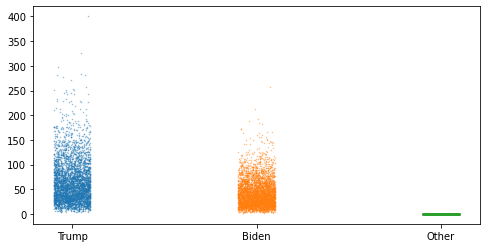

Alaska
[[3.61996245e+01 3.24437615e+01 5.43814914e-02]
 [1.22983060e+03 1.11843242e+03 6.04125980e-01]]


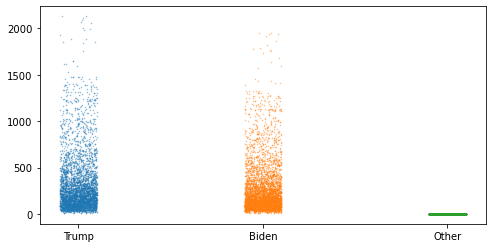

Arizona
[[30.39239724 32.8154411   0.12670294]
 [59.15300048 63.44614759  0.29275313]]


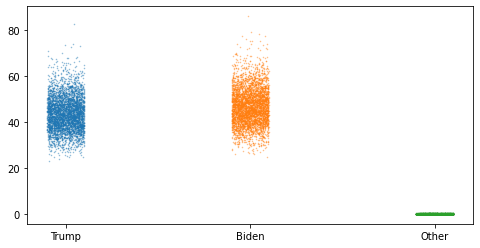

Arkansas
[[1.68455309e+00 1.12776418e+00 3.26411571e-02]
 [5.73287591e+01 3.54249653e+01 2.85946117e-01]]


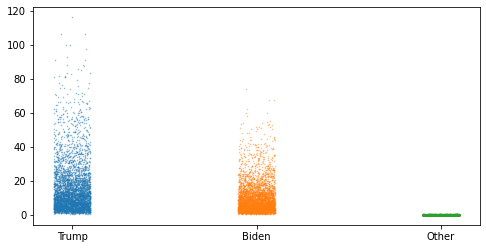

California
[[7.12808061e+00 1.32219682e+01 5.67891996e-02]
 [3.56498658e+01 6.71111806e+01 2.28860859e-01]]


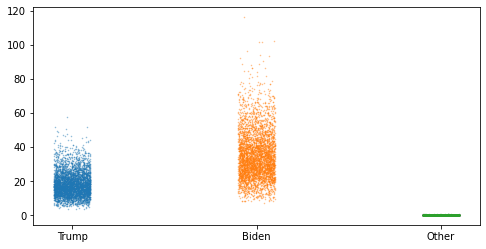

Colorado
[[3.02362817e+01 3.91879563e+01 6.52939560e-02]
 [1.26235760e+02 1.66206902e+02 2.32033084e-01]]


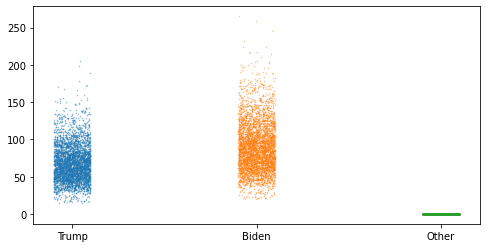

Connecticut
[[5.66586086e+00 9.77115742e+00 4.56376119e-02]
 [5.14598765e+02 9.29840088e+02 7.68074012e-01]]


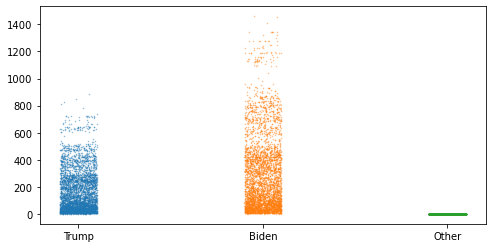

Delaware
[[1.84717196e+00 3.15159944e+00 4.55761304e-02]
 [4.29631769e+01 7.64438036e+01 5.65782380e-01]]


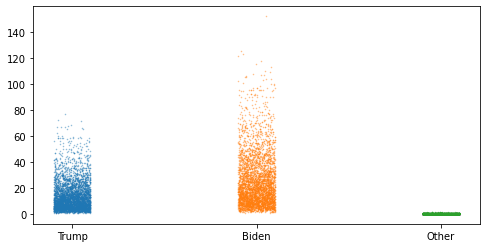

District of Columbia
[[5.60876683e-01 2.51792347e+00 3.63665082e-02]
 [2.55414262e+01 1.83680116e+02 5.29207542e-01]]


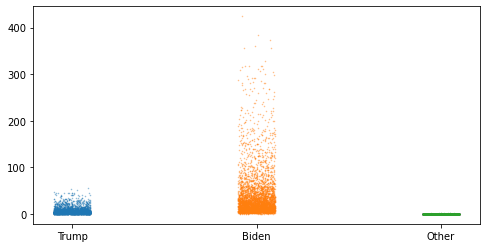

Florida
[[39.82824216 43.26008246  0.10398855]
 [76.04392352 82.15900534  0.22092538]]


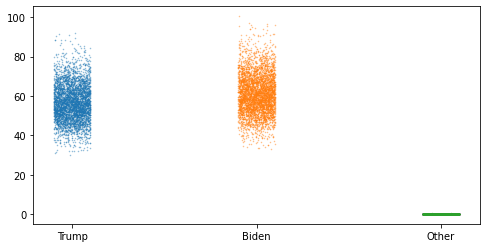

Georgia
[[31.26471973 31.0520927   0.11834642]
 [73.54473367 73.46407326  0.33599992]]


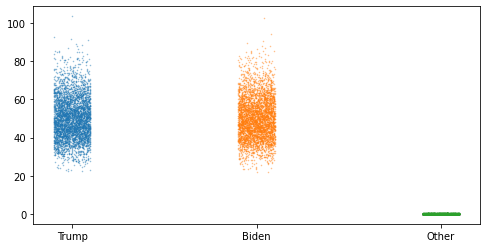

Hawaii
[[1.84155274e+00 3.38616963e+00 3.84112039e-02]
 [1.66568042e+02 3.15135543e+02 5.24036850e-01]]


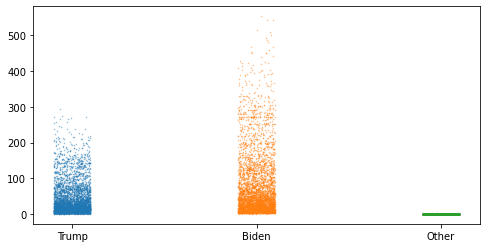

Idaho
[[2.64188054e+00 1.68674761e+00 3.57526387e-02]
 [3.02320060e+02 1.83100353e+02 4.34292298e-01]]


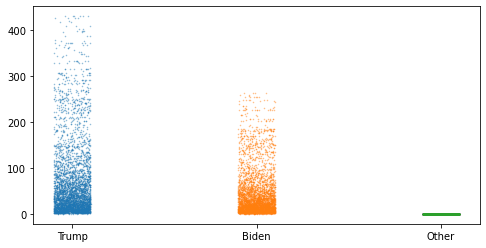

Illinois
[[2.14277384e+00 3.05310956e+00 3.44127355e-02]
 [3.45965441e+02 5.45042251e+02 2.76731720e-01]]


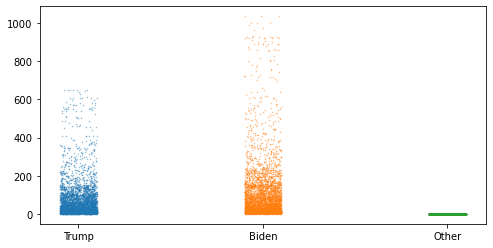

Indiana
[[4.88261382e+00 3.77048540e+00 4.57735714e-02]
 [6.84184613e+01 5.31041554e+01 2.89305298e-01]]


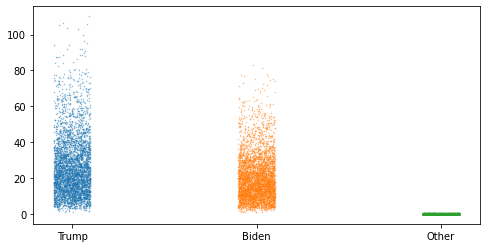

Iowa
[[23.72326202 22.94558748  0.08968276]
 [83.60701447 81.91957101  0.33544379]]


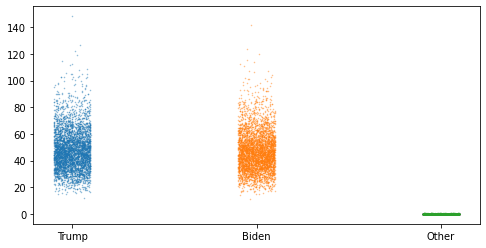

Kansas
[[1.92029444e+01 1.58764504e+01 5.30071149e-02]
 [1.72495126e+02 1.43041306e+02 3.26460954e-01]]


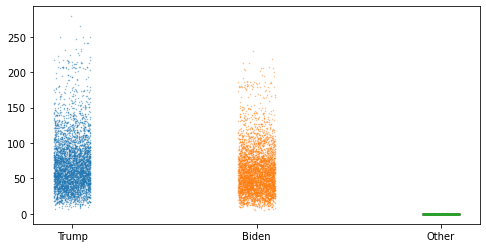

Kentucky
[[4.57521589e+01 3.06720758e+01 6.08245336e-02]
 [2.80177657e+02 1.89258890e+02 3.03125107e-01]]


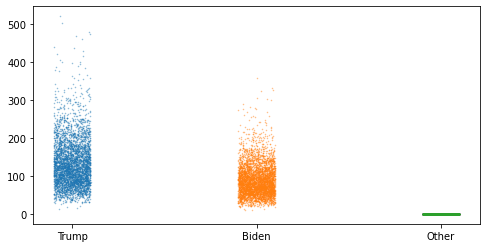

Louisiana
[[3.07193589e+00 2.18951497e+00 5.57415816e-02]
 [5.83112999e+01 4.03958423e+01 3.96508100e-01]]


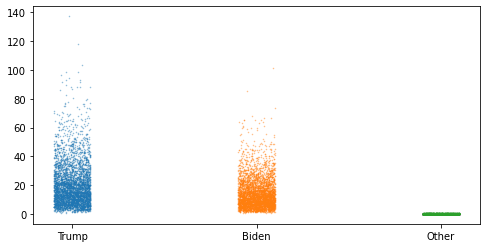

Maine
[[3.14062775e+01 4.04160027e+01 7.14102306e-02]
 [1.21303169e+02 1.60600521e+02 1.86138874e-01]]


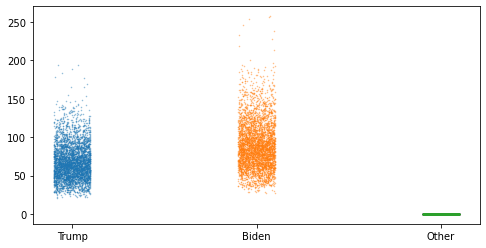

Maryland
[[3.60841434e+00 7.35319460e+00 5.11233223e-02]
 [5.20207786e+01 1.03837144e+02 3.30563878e-01]]


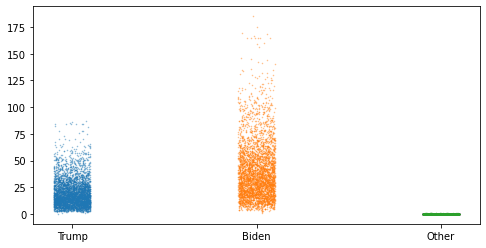

Massachusetts
[[2.14125850e+01 4.81237392e+01 4.91198493e-02]
 [2.99946527e+02 6.82352911e+02 3.83791803e-01]]


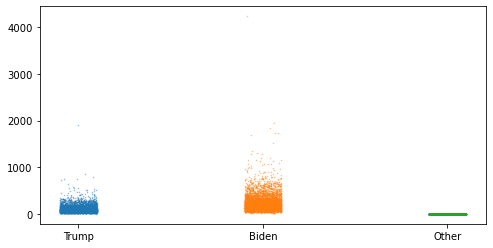

Michigan
[[39.31135284 46.08883423  0.11859711]
 [71.40066217 83.81301668  0.24261581]]


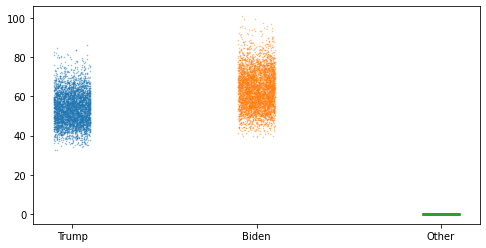

Minnesota
[[2.88914681e+01 3.46529767e+01 8.39692804e-02]
 [8.55078483e+01 1.01245666e+02 2.47532205e-01]]


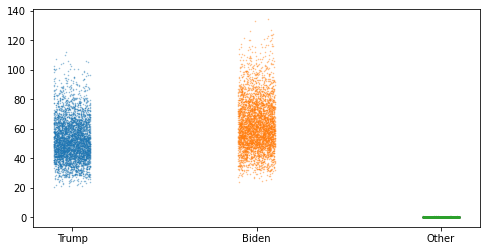

Mississippi
[[1.18719358e+01 8.67419875e+00 4.71645073e-02]
 [3.99169335e+02 2.86564285e+02 4.21795817e-01]]


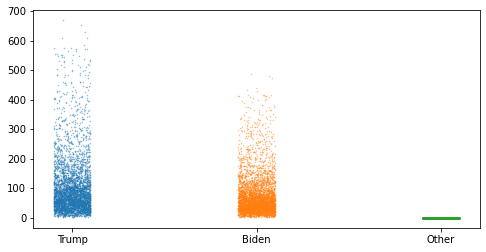

Missouri
[[1.39749544e+02 1.23004881e+02 7.01406779e-02]
 [2.00245046e+03 1.71759426e+03 5.98597811e-01]]


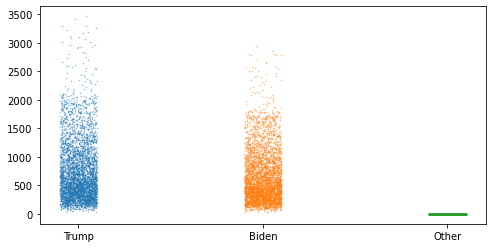

Montana
[[3.30391511e+01 2.82179882e+01 7.50023746e-02]
 [1.56031141e+02 1.29757171e+02 3.55748827e-01]]


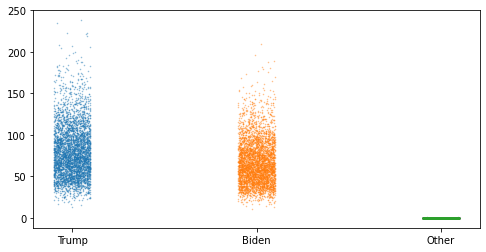

Nebraska
[[1.17664941e+01 1.17592252e+01 4.75880814e-02]
 [1.31990374e+02 1.28383137e+02 2.82000944e-01]]


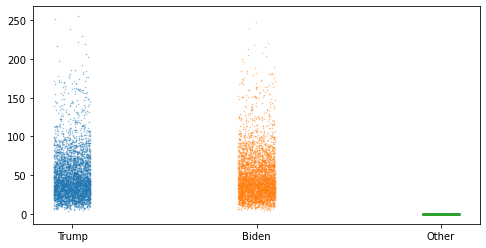

Nevada
[[ 9.67377241 10.45841707  0.07053825]
 [60.65483339 66.34849317  0.40150641]]


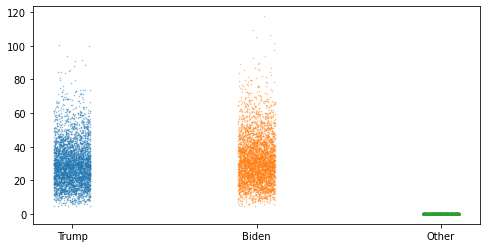

New Hampshire
[[1.63235456e+01 2.05073673e+01 8.17669695e-02]
 [8.18343192e+01 1.02199650e+02 4.08319827e-01]]


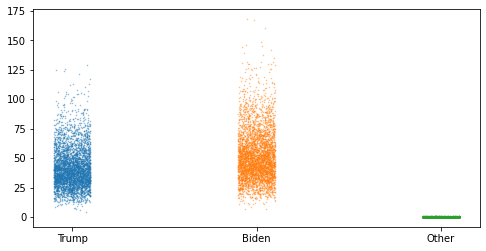

New Jersey
[[2.48440851e+01 3.63720017e+01 5.50350413e-02]
 [3.50252392e+02 5.14393084e+02 3.04395893e-01]]


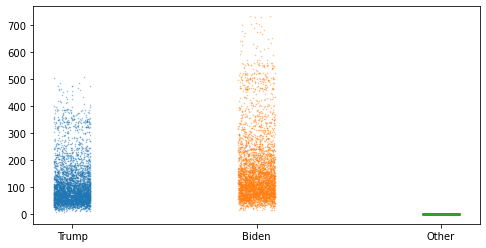

New Mexico
[[1.21911331e+01 1.47403695e+01 4.28447984e-02]
 [3.19274047e+02 4.01380519e+02 4.14156447e-01]]


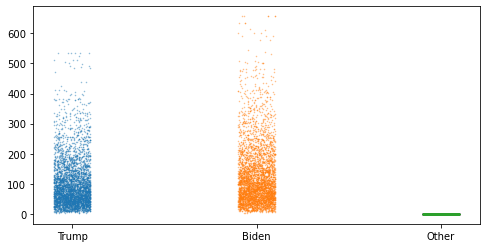

New York
[[8.86779972e+01 1.66535513e+02 5.98134300e-02]
 [4.02975900e+03 7.59441513e+03 6.57122538e-01]]


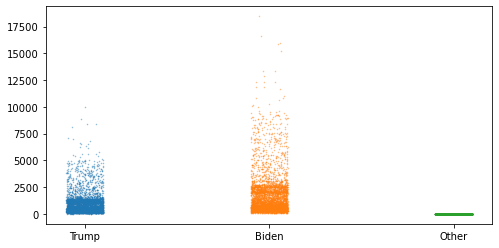

North Carolina
[[28.71197643 29.9094806   0.15387597]
 [56.6402838  58.80952923  0.35639033]]


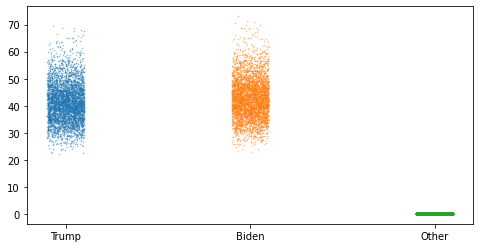

North Dakota
[[3.62597041e+00 2.09699752e+00 4.11684716e-02]
 [3.83863677e+02 2.32497501e+02 5.38447926e-01]]


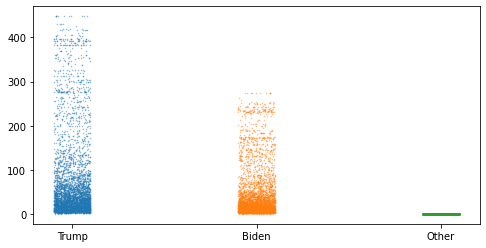

Ohio
[[21.57685049 21.8177187   0.08345375]
 [63.66533011 62.62326586  0.2699326 ]]


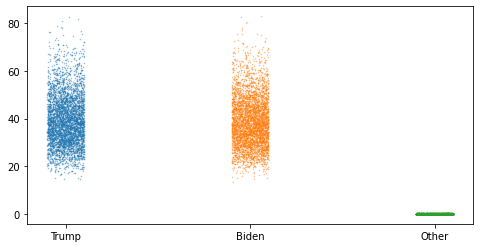

Oklahoma
[[4.59638821e+01 2.71159359e+01 5.62403202e-02]
 [1.24100189e+03 7.24291367e+02 7.06813459e-01]]


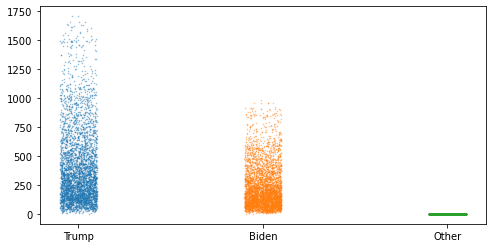

Oregon
[[5.89015735e+00 9.14702514e+00 3.89100928e-02]
 [5.06451631e+02 7.84332606e+02 4.44830432e-01]]


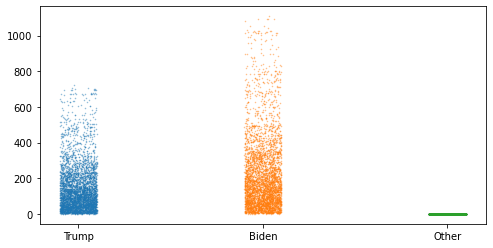

Pennsylvania
[[41.93117505 47.02556219  0.12017663]
 [77.99429946 88.28772777  0.24539318]]


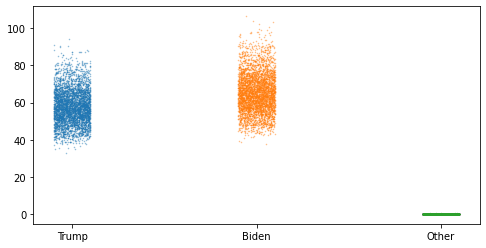

Rhode Island
[[1.06951865e+00 1.55081434e+00 3.54772599e-02]
 [1.56011043e+02 2.36307320e+02 1.01381796e+00]]


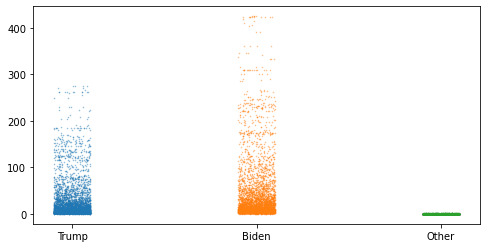

South Carolina
[[5.93784128e+02 5.19674329e+02 9.77611382e-02]
 [9.09926784e+03 7.89827455e+03 1.05243253e+00]]


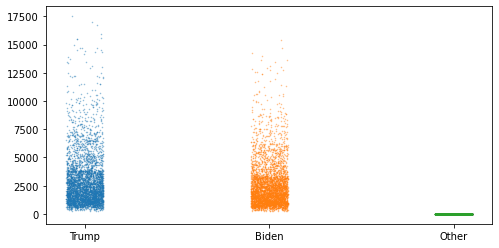

South Dakota
[[1.53086951e+00 1.04264799e+00 3.47601136e-02]
 [1.88734865e+02 1.16429189e+02 5.84477873e-01]]


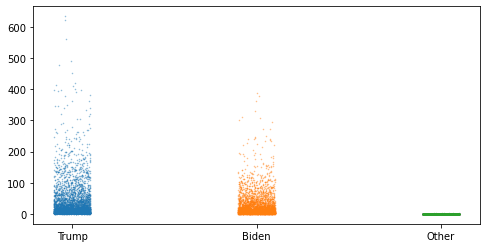

Tennessee
[[5.17380593e+00 3.58450776e+00 3.68889018e-02]
 [5.34783022e+02 3.54119319e+02 3.53813155e-01]]


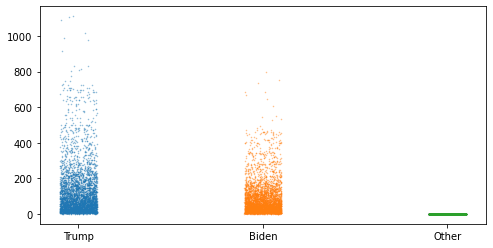

Texas
[[4.03934487e+01 3.90862280e+01 8.36672876e-02]
 [9.65425026e+01 9.26423428e+01 2.05693193e-01]]


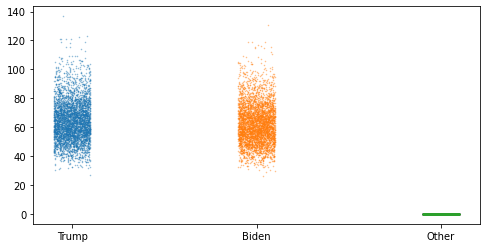

Utah
[[ 4.19978649  3.15907827  0.05710894]
 [41.20796559 29.90374962  0.34081822]]


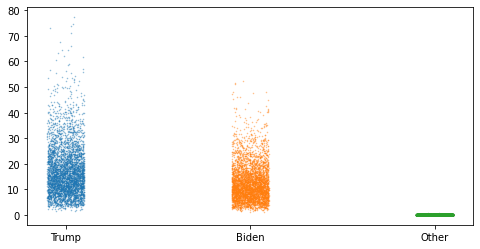

Vermont
[[1.15192500e+00 2.29071055e+00 3.28669281e-02]
 [4.00435975e+01 9.20668777e+01 3.54901263e-01]]


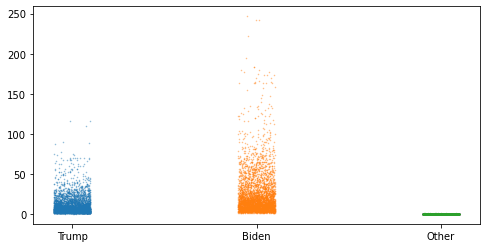

Virginia
[[1.34217547e+02 1.75742774e+02 6.44743318e-02]
 [3.98478895e+03 5.20862287e+03 7.26471208e-01]]


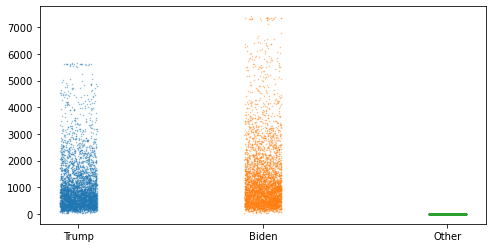

Washington
[[1.96660996e+01 3.34965645e+01 4.77399988e-02]
 [1.20269021e+03 2.10627426e+03 3.82317936e-01]]


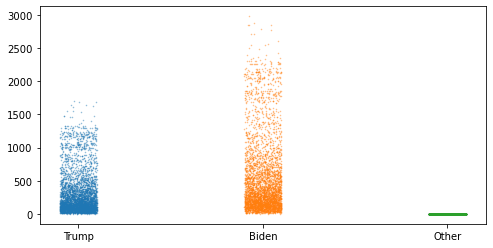

West Virginia
[[1.99457276e+00 1.22530229e+00 3.28506214e-02]
 [1.02650892e+02 5.34249700e+01 3.50650361e-01]]


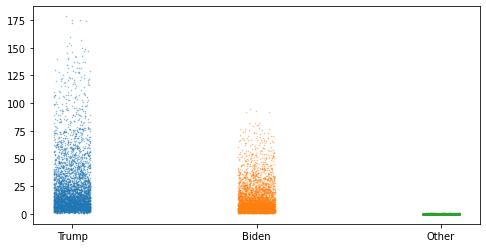

Wisconsin
[[33.64050446 38.19158682  0.12423141]
 [60.28502373 68.94323793  0.2510807 ]]


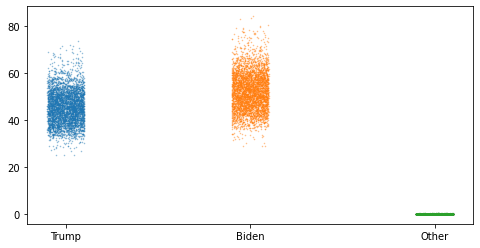

Wyoming
[[1.56002455e+00 7.41151734e-01 3.42456656e-02]
 [3.19812926e+02 1.38517399e+02 6.36877483e-01]]


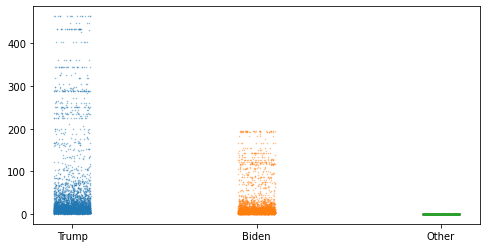

In [7]:
print('Posterior α samples and 95% confidence intervals for each state\n')
for state in states:
    print(state)
    samples = results[state].extract()
    print(np.percentile(samples['alpha'], [2.5, 97.5], axis=0))
    plt.figure(figsize=(8,4))
    for i in range(3):
        plt.plot(sts.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), samples['alpha'][:,i], '.', markersize=1, alpha=0.5)
    plt.xticks([0, 1, 2], ['Trump', 'Biden', 'Other'])
    plt.show()

/Users/inventrohyder/anaconda3/envs/minerva/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


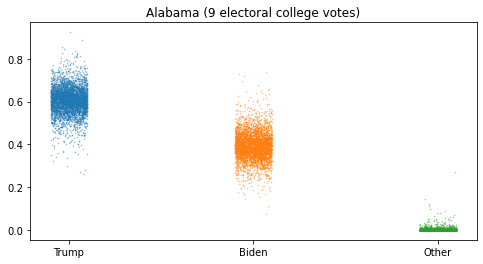

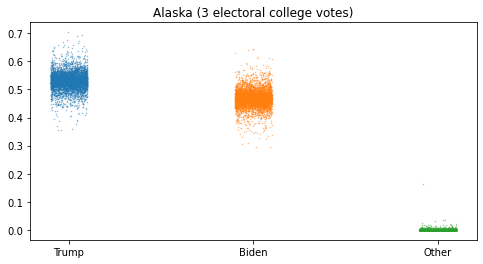

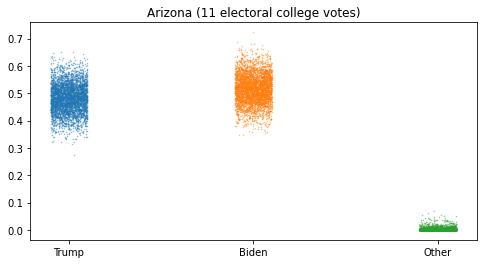

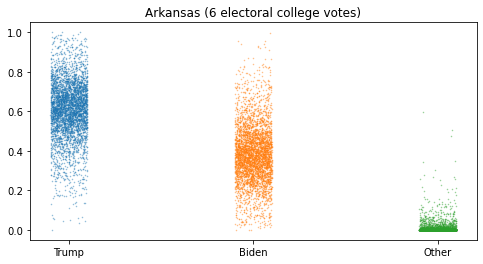

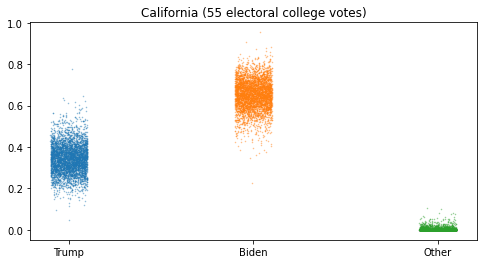

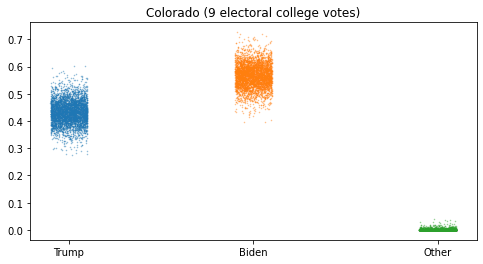

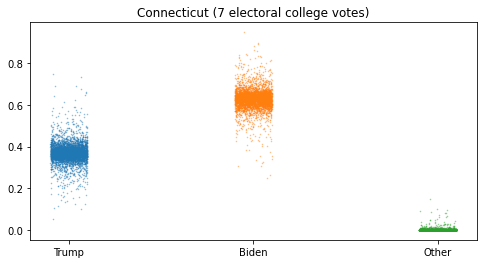

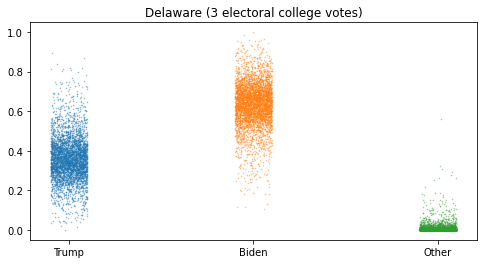

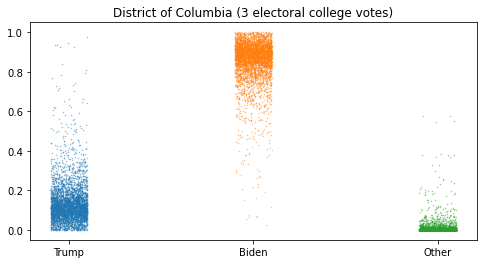

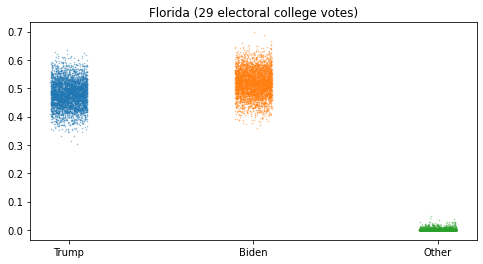

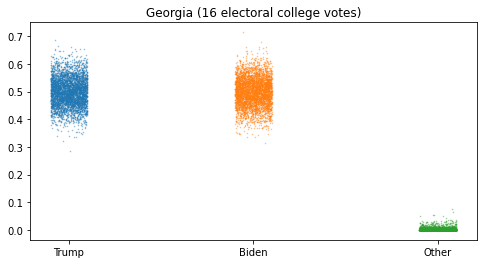

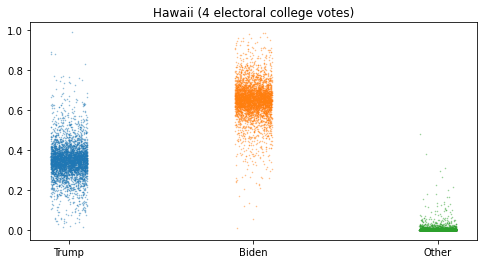

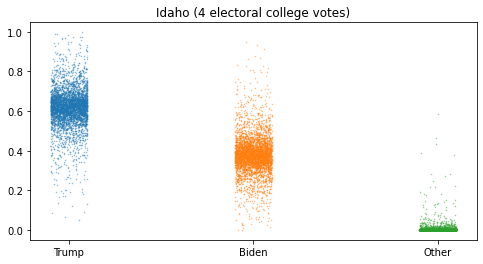

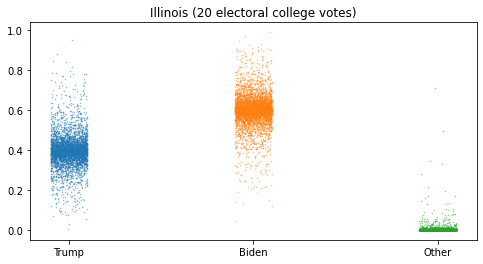

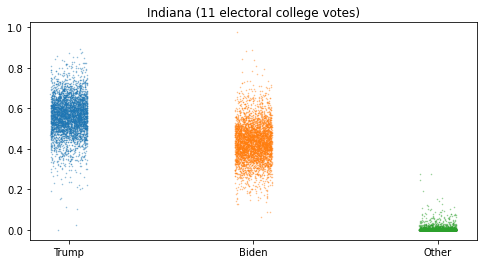

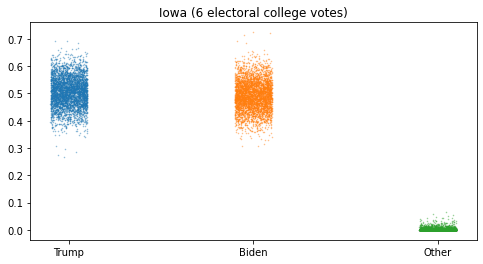

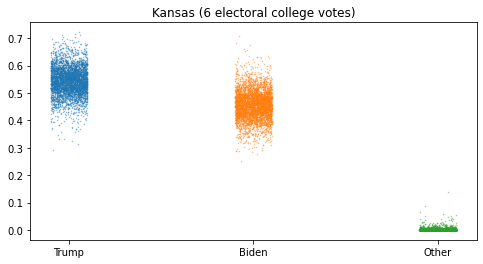

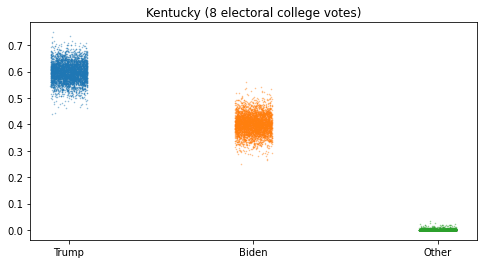

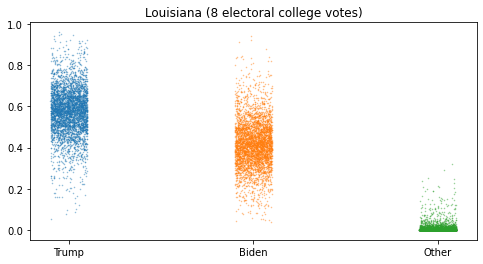

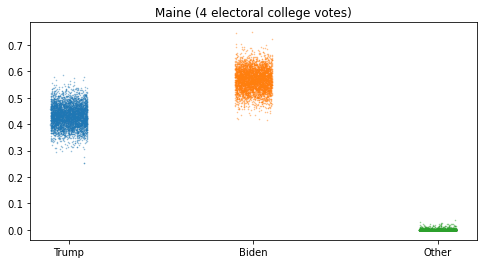

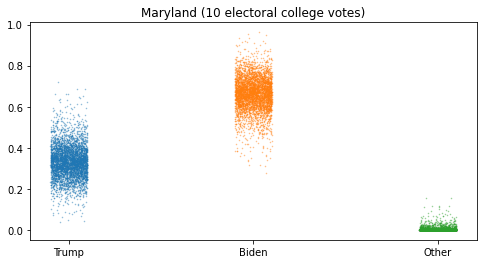

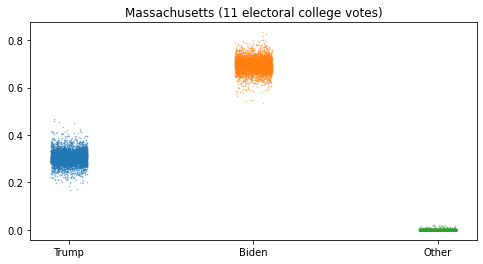

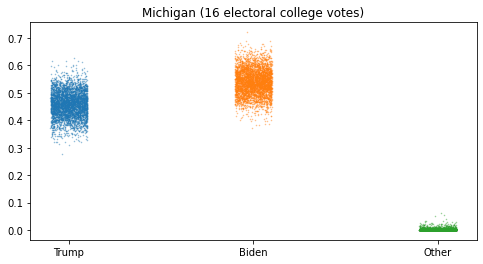

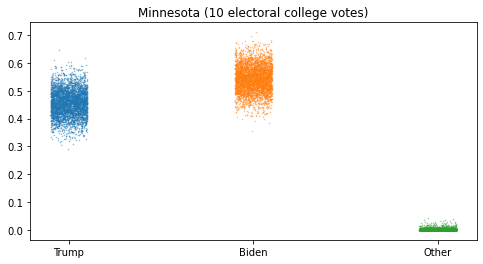

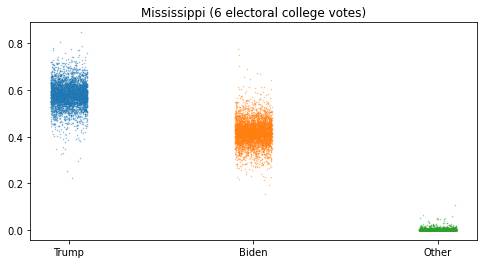

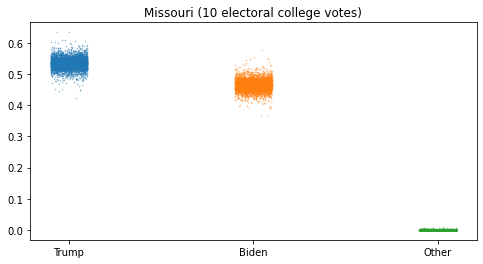

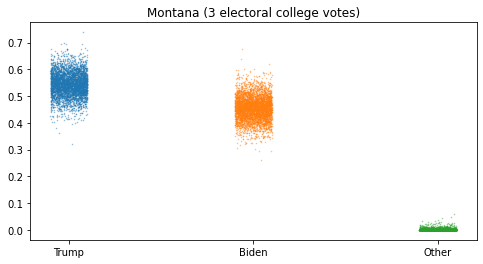

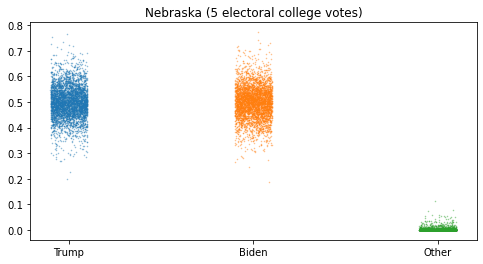

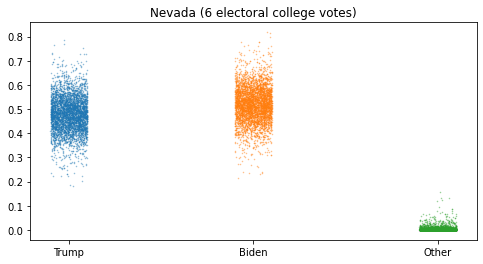

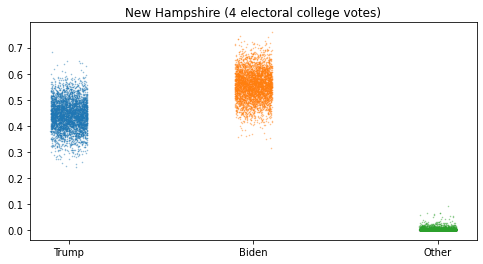

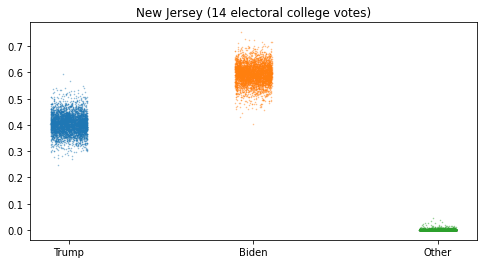

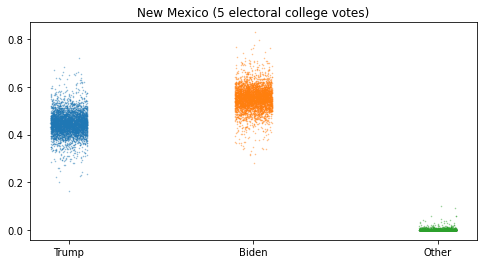

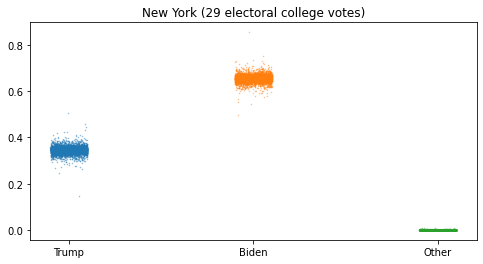

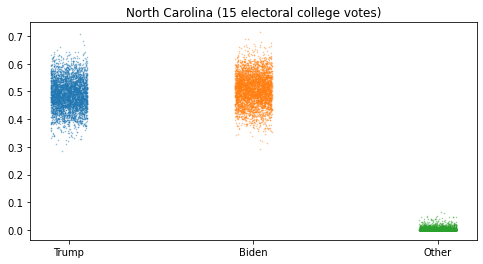

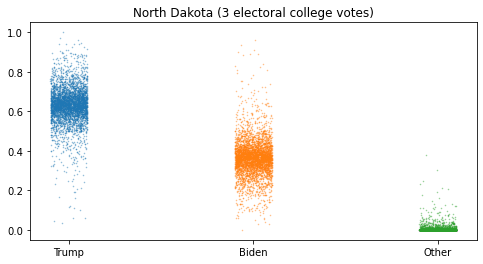

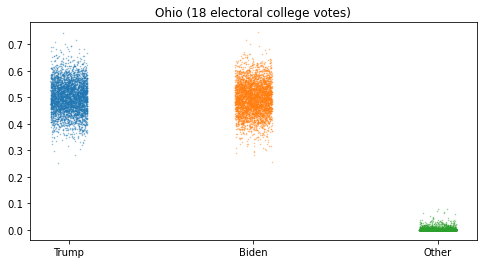

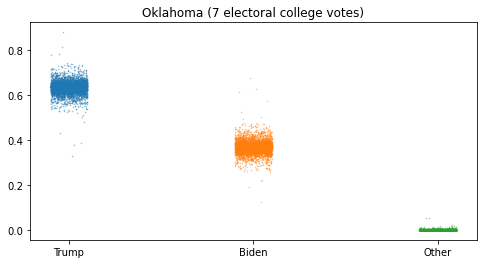

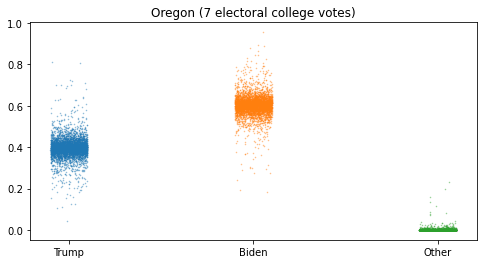

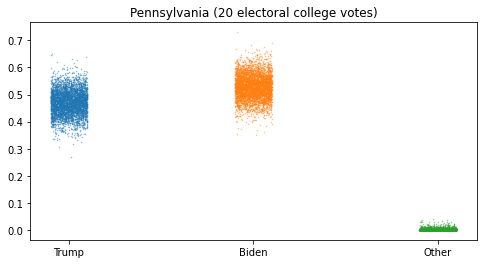

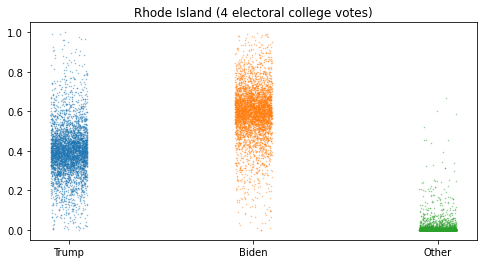

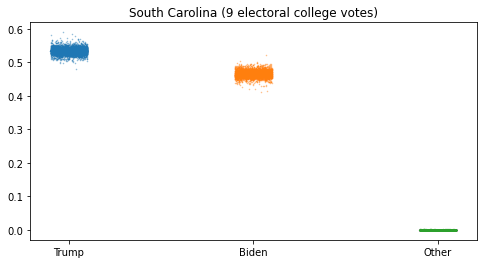

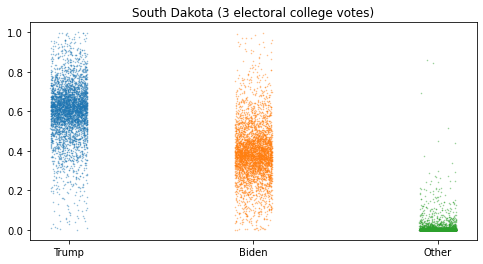

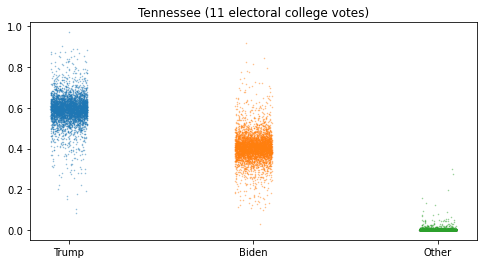

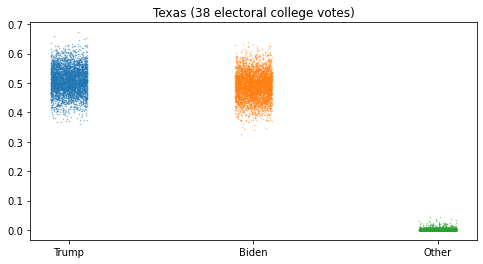

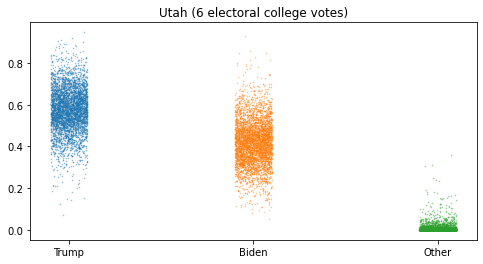

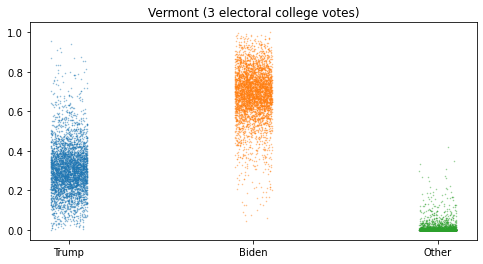

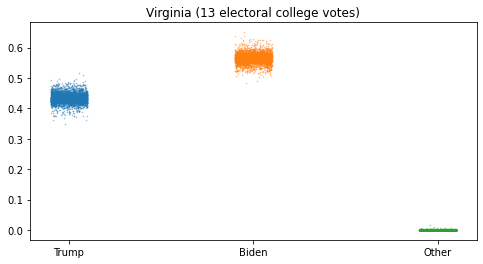

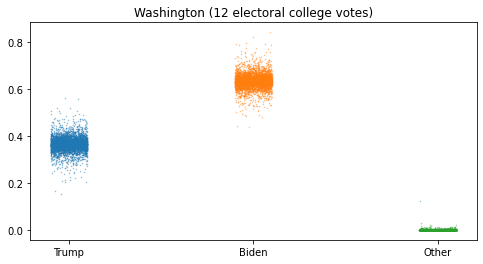

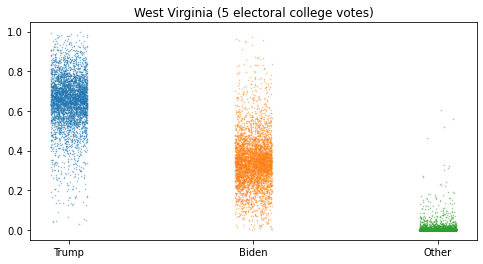

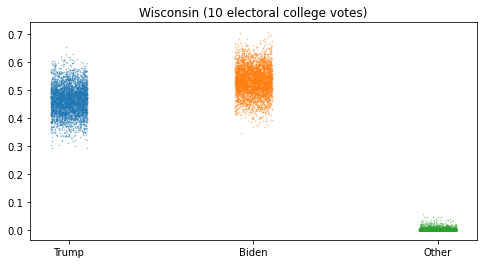

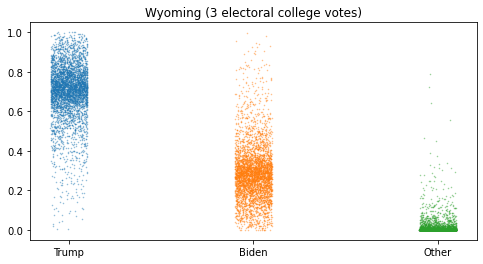

In [8]:
# Generating predictive samples using SciPy

for state in states:

    # Use the posterior alpha samples to generate posterior predictive samples for p.
    # Each p represents the fraction of votes each candidate would get in each state
    # during an election.
    samples = results[state].extract()
    alpha = samples['alpha']
    p_predicted = np.empty(alpha.shape)
    for i in range(alpha.shape[0]):
        p_predicted[i] = sts.dirichlet.rvs(alpha[i])

    # Plot the results
    plt.figure(figsize=(8,4))
    for i in range(3):
        plt.plot(sts.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), p_predicted[:,i], '.', markersize=1, alpha=0.5)
    plt.title(state + ' (' + str(electoral_votes[state]) + ' electoral college votes)')
    plt.xticks([0, 1, 2], ['Trump', 'Biden', 'Other'])

plt.show()

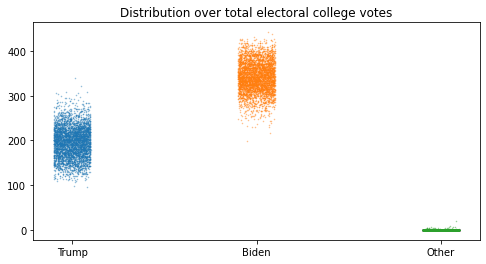

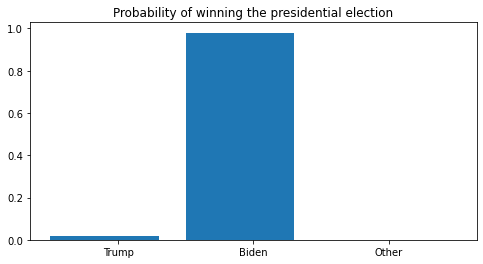

In [9]:
# Generating winner simulation using SciPy
samples = {state: results[state].extract() for state in states}

# Use the posterior predictive probability that each candidate will win each state
# to generate samples over the total number Electoral College votes each candidate
# would get in an election.
total_votes = np.zeros((4000, 3))
overall_winner = np.zeros(4000)
for s in range(4000):
    for state in states:
        alpha = samples[state]['alpha'][s]
        p_predicted = sts.dirichlet.rvs(alpha)
        winner = p_predicted.argmax()
        total_votes[s, winner] += electoral_votes[state]
    overall_winner[s] = total_votes[s].argmax()

# Plot national results
plt.figure(figsize=(8,4))
for i in range(3):
    plt.plot(sts.uniform.rvs(loc=i-0.1, scale=0.2, size=4000), total_votes[:,i], '.', markersize=1, alpha=0.5)
plt.xticks([0, 1, 2], ['Trump', 'Biden', 'Other'])
plt.title('Distribution over total electoral college votes')

plt.figure(figsize=(8,4))
plt.hist(overall_winner, bins=[-0.5, 0.5, 1.5, 2.5], width=0.8, align='mid', density=True)
plt.xticks([0, 1, 2], ['Trump', 'Biden', 'Other'])
plt.title('Probability of winning the presidential election')
plt.show()

Oklahoma              99.8%   0.2%  0.0%
South Carolina        99.2%   0.8%  0.0%
Kentucky              99.0%   1.0%  0.0%
Missouri              95.6%   4.4%  0.0%
Alabama               95.2%   4.8%  0.0%
North Dakota          94.4%   5.5%  0.0%
Mississippi           93.9%   6.1%  0.0%
Tennessee             93.2%   6.8%  0.0%
Wyoming               92.1%   7.7%  0.1%
Idaho                 91.1%   8.8%  0.1%
West Virginia         89.3%  10.7%  0.1%
Alaska                84.6%  15.4%  0.0%
Montana               84.0%  16.0%  0.0%
South Dakota          83.6%  16.2%  0.2%
Arkansas              81.5%  18.4%  0.1%
Kansas                80.6%  19.4%  0.0%
Louisiana             79.9%  20.1%  0.0%
Indiana               79.7%  20.3%  0.0%
Utah                  77.7%  22.3%  0.0%
Texas                 57.3%  42.7%  0.0%
Iowa                  53.4%  46.6%  0.0%
Ohio                  52.1%  47.9%  0.0%
Nebraska              50.2%  49.8%  0.0%
Georgia               48.9%  51.1%  0.0%
North Carolina  

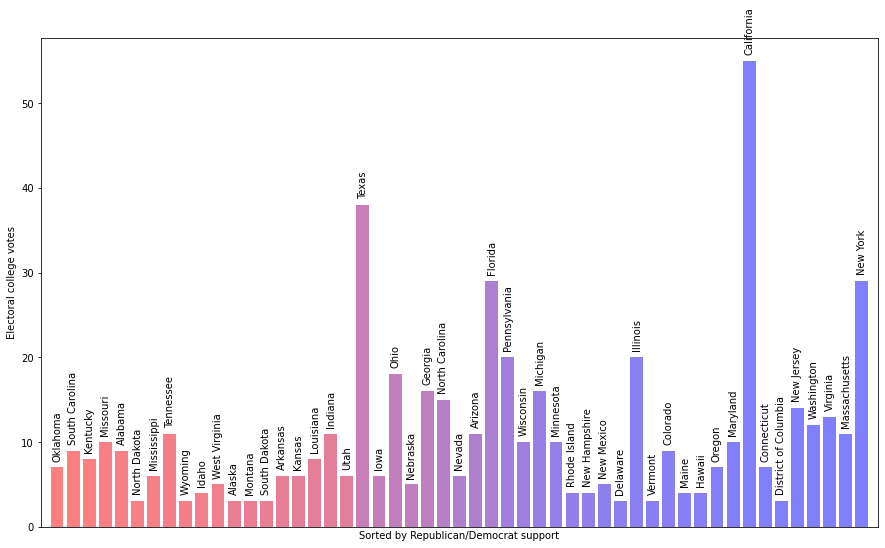

In [13]:
from scipy.special import softmax
expected_prob = {
    state: np.mean(softmax(np.array([
        sts.dirichlet.rvs(alpha)[0] for alpha in samples[state]['alpha']])*100, axis=1), axis=0)
    for state in states}
sorted_states = sorted(expected_prob.items(), key=lambda x: x[1][1])

for state, prob in sorted_states:
    print(f'{state:20}  {100*prob[0]:4.1f}%  {100*prob[1]:4.1f}%  {100*prob[2]:3.1f}%')

plt.figure(figsize=(15,9))
plt.ylabel('Electoral college votes')
plt.xlabel('Sorted by Republican/Democrat support')
plt.xticks([])
plt.xlim(-1, 51)
red = np.array([1, 0, 0])
blue = np.array([0, 0, 1])
plt.bar(np.arange(len(states)), [electoral_votes[s] for s, p in sorted_states], color=[p[0] * red + p[1] * blue for s, p in sorted_states], alpha=0.5)
for i, (state, p) in enumerate(sorted_states):
    plt.text(i, electoral_votes[state] + 1, state, rotation='vertical', horizontalalignment='center')
plt.show()